## AIML CA2 PART A - TIME SERIES
Objective : Using the Energy Consumption Dataset, train time series models and forecast the gas consumption, electricity consumption and water consumption in the future.

Background Information : You are given a csv dataset <b>Energy Consumption Dataset.csv</b> to build your time series model.

### IMPORTING DATASETS

1. Import numpy, pandas, plotly, seaborn, sklearn and other relevant modules required.

2. Read the csv data file 'Energy Consumption Dataset.csv' using pd.read_csv.

In [112]:
# Importing the relevant modules and libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import math

# Importing the sklearn and statsmodels libraries
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
from scipy import signal
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import lag_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Removing and Filtering Warning Messages
import warnings
warnings.filterwarnings("ignore")

# Load the dataset using pandas
energy_df = pd.read_csv('Datasets/Energy Consumption Dataset.csv')

### OVERVIEW AND LOADING OF THE ENERGY CONSUMPTION DATASET

Obtain an summarised view of the dataset by using pandas functions .info() to get summarized information of the dataset, and use .head() to display the first 5 rows of the dataset.

In [2]:
# Viewing of the customer_df.csv
print("Overview and Summary of Energy Consumption Dataset.csv : \n")
print("Number of datapoints :", len(energy_df), "\n")
print(energy_df.info())

# Obtain the first 5 rows of the dataset
energy_df.head()

Overview and Summary of Energy Consumption Dataset.csv : 

Number of datapoints : 397 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE                           397 non-null    object 
 1   Gas Consumption (tons)         397 non-null    float64
 2   Electricity Consumption (MWh)  397 non-null    float64
 3   Water Consumption (tons)       397 non-null    float64
dtypes: float64(3), object(1)
memory usage: 12.5+ KB
None


,DATE,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
0,1/1/1990,18.0,725.1,548.8
1,1/2/1990,15.8,706.7,640.7
2,1/3/1990,17.3,624.5,511.1
3,1/4/1990,18.9,574.7,515.3
4,1/5/1990,22.0,553.2,488.4


### INITIAL ANALYSIS FROM THE OVERVIEW OF THE DATASET
- There are no missing values in the energy consumption dataset, hence data cleaning is not needed.
- There are 397 rows of data points in the customer dataset.
- 'DATE' column has an object datatype, while the rest have float datatypes. Hence, 'DATE' needs to be converted to a DateTime format and set as the index of the dataframe.

### WRANGLING AND PRE-PROCESSING OF THE DATASET
- Rename the 'DATE' column to 'Date' to standardize capitalization across the column names in the dataset.

- Since 'DATE' is an object datatype, convert it to <b>DATETIME format</b> to enable time series forecasting.

- Set the 'Date' column as the index of the dataframe to enable time-based indexing and allows for various time-based operations.

In [3]:
# Wrangling and Pre-Processing of the Energy Consumption Dataset

# Create a copy of the dataset
energy_df_final = energy_df.copy()

# Rename the 'DATE' column to 'Date' to ensure standardization in capitalization
energy_df_final = energy_df_final.rename(columns = {"DATE" : "Date"})

# Convert the Date column to DATETIME formatting
energy_df_final['Date'] = pd.to_datetime(energy_df_final['Date'], format = '%d/%m/%Y')

# Set the Date column as the index of the dataframe
energy_df_final.set_index('Date', inplace = True)

# View the first 5 rows of the updated dataframe
energy_df_final.head()

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
Date,,,
1990-01-01,18.0,725.1,548.8
1990-02-01,15.8,706.7,640.7
1990-03-01,17.3,624.5,511.1
1990-04-01,18.9,574.7,515.3
1990-05-01,22.0,553.2,488.4


### DESCRIBING THE INFORMATION OF THE ENERGY CONSUMPTION DATASET

- Determine the number of rows and columns in the dataset : use shape[0] for rows and shape[1] for columns.

- Ensure the dataset does not contain NA values : use .isnull().sum() to sum the NA values by column (if any). If values are returned as 0, it indicates that there are no NA values.

- Retrieve the number of unique values for each column in the dataset using nunique().

- Obtain numerical summaries for numerical columns in the dataset by using .describe() and retrieve its statistical values.

In [4]:
# Information of the dataset

# Extracting the rows and columns of the dataset
print(f"\nThere are {energy_df_final.shape[0]} rows and {energy_df_final.shape[1]} columns in the energy_df dataset.")

# Check for any missing values
print(f"\nChecking for missing or na values in the dataset:\n---------------------------\n{energy_df_final.isnull().sum()}")

# Extract the unique values from each column of the dataset
print(f"\nCount of unique values in the dataset columns:\n---------------------------\n{energy_df_final.nunique()}")

# Describing the dataset with numerical summaries
print(f"\nSummarising the numerical values in the dataset:\n---------------------------\n{energy_df_final.describe()}")


There are 397 rows and 3 columns in the energy_df dataset.

Checking for missing or na values in the dataset:
---------------------------
Gas Consumption (tons)           0
Electricity Consumption (MWh)    0
Water Consumption (tons)         0
dtype: int64

Count of unique values in the dataset columns:
---------------------------
Gas Consumption (tons)           161
Electricity Consumption (MWh)    383
Water Consumption (tons)         319
dtype: int64

Summarising the numerical values in the dataset:
---------------------------
       Gas Consumption (tons)  Electricity Consumption (MWh)  \
count              397.000000                     397.000000   
mean                23.785139                     888.472544   
std                  4.903452                     153.877594   
min                 11.600000                     553.200000   
25%                 20.200000                     771.100000   
50%                 23.500000                     897.800000   
75%              

### EXPLORATORY DATA ANALYSIS

### GRAPH 1 : UNDERSTANDING DISTRIBUTIONS AND PATTERNS IN ENERGY CONSUMPTION VARIABLES

- The pairplot reveals that the distributions of gas, electricity, and water consumption variables appear to be relatively normalized, with limited presence of outliers that might distort the distribution values. Hence, this suggests that the energy consumption for gas, electricity and water follow a normal distribution with no skewed data, so the variables are relatively stable and consistent over time.


- From the scatterplot, it indicates that there are no significant correlations and patterns between energy consumption variables, thereby suggesting the absence of exogenous variables in the dataset. Hence, the lack of a pattern suggests a degree of independence between the variables, and each energy source is driven by its own unique factors.

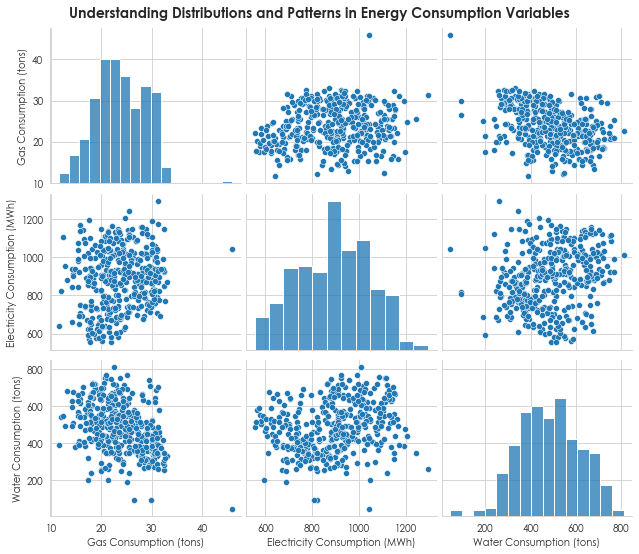

In [5]:
# Graph 1 : UNDERSTANDING DISTRIBUTIONS AND PATTERNS IN ENERGY CONSUMPTION VARIABLES

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Plot the pairplot
pairplot = sns.pairplot(energy_df_final, aspect=1.2, palette='Dark2')

# Plot customization
plt.suptitle('Understanding Distributions and Patterns in Energy Consumption Variables', y=1.02, fontsize=14, fontweight='bold')

# Display the plot
plt.show()

### GRAPH 2 : INVESTIGATING ENERGY CONSUMPTION TRENDS FROM 1990 TO 2023

- For gas, electricity and water sources, there has been fluctuations in energy consumption over the years, which could be influenced by dynamic factors that lead to changes in usage patterns, such as weather conditions and economic activities. The role of technological innovations and shifts in consumer behavior also contribute to the fluctuations, as advances in energy-efficient technologies and changing consumer preferences can influence consumption levels. 


- Based on the recurring rises and falls in energy consumption for gas, water and electricity, it shows the presence of seasonality or cyclical patterns, in which there are specific time periods in which the variables experience higher or lower energy demand. This visible pattern enables anticipation for peak energy demand periods and optimization of resource allocation. This also indicates that the SARIMA model is more suitable to forecast future values for the respective energy consumption variables.


- However, for electricity, there has been a steady increase in electricity consumption from 1990 to 2023, which could be due to increased interconnectivity and usage of electronic devices over the years. Overall, this rise in energy consumption can be reflected by society'ds growing demand for energy-intensive services with increased urbanization.

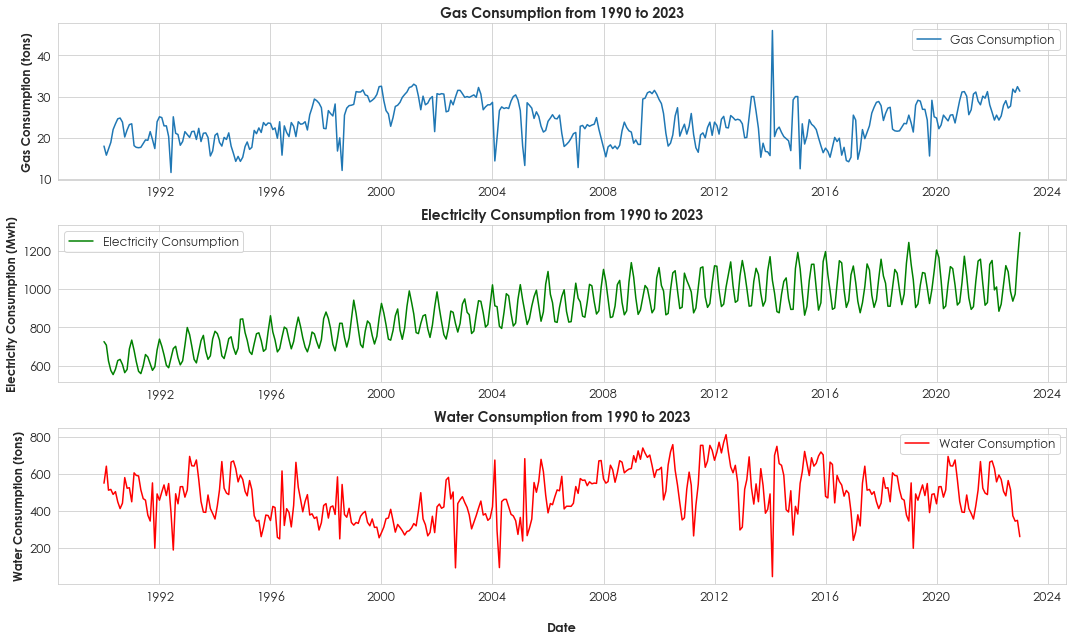

In [6]:
# Graph 2 : INVESTIGATING ENERGY CONSUMPTION TRENDS FROM 1990 TO 2023

# Creating subplots for each variable
fig, axs = plt.subplots(3, 1, figsize=(15, 9))

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Plotting Gas Consumption
axs[0].plot(energy_df_final.index, energy_df_final['Gas Consumption (tons)'], label='Gas Consumption')
axs[0].set_ylabel('Gas Consumption (tons)', fontsize=12, fontweight='bold')
axs[0].set_title('Gas Consumption from 1990 to 2023', fontsize=14, fontweight='bold')
axs[0].legend(fontsize=12)

# Plotting Electricity Consumption
axs[1].plot(energy_df_final.index, energy_df_final['Electricity Consumption (MWh)'], color='green', label='Electricity Consumption')
axs[1].set_ylabel('Electricity Consumption (Mwh)', fontsize=12, fontweight='bold')
axs[1].set_title('Electricity Consumption from 1990 to 2023', fontsize=14, fontweight='bold')
axs[1].legend(fontsize=12)

# Plotting Water Consumption
axs[2].plot(energy_df_final.index, energy_df_final['Water Consumption (tons)'], color='red', label='Water Consumption')
axs[2].set_ylabel('Water Consumption (tons)', fontsize=12, fontweight='bold')
axs[2].set_title('Water Consumption from 1990 to 2023', fontsize=14, fontweight='bold')
axs[2].legend(fontsize=12)

plt.xlabel('Date', fontsize=13, fontweight='bold', labelpad=20)

# Adjust the x-axis tick label font size
for ax in axs:
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()

### GRAPH 3 : EXPLORING CAUSATION BETWEEN GAS, WATER AND ELECTRICITY CONSUMPTION

The Granger Causality Test is used for this EDA plot. It is a statistical hypothesis test for determining whether one time series is a factor and offer useful information in forecasting another time series. This enables us to conclude if Multivariate Modelling can be used for this time series.

Note : If correlation coefficient is less than the significant level (0.05), then we can reject the null hypothesis (`H0`) and conclude that the x value will Granger-cause y value.

**Gas Consumption (tons) as Causal Variable:**

- Gas Consumption (tons) vs. Electricity Consumption (MWh): p-value = 0.3018
- Gas Consumption (tons) vs. Water Consumption (tons): p-value = 0.2368


- Interpretation: There is no strong evidence to suggest that changes in Gas Consumption (tons) Granger-cause significant changes in Electricity Consumption (MWh) or Water Consumption (tons).

**Electricity Consumption (MWh) as Causal Variable:**

- Electricity Consumption (MWh) vs. Gas Consumption (tons): p-value = 0.1018
- Electricity Consumption (MWh) vs. Water Consumption (tons): p-value = 0.1045


- Interpretation: There is no strong evidence to suggest that changes in Electricity Consumption (MWh) Granger-cause significant changes in Gas Consumption (tons) or Water Consumption (tons).

**Water Consumption (tons) as Causal Variable:**

- Water Consumption (tons) vs. Gas Consumption (tons): p-value = 0.0335
- Water Consumption (tons) vs. Electricity Consumption (MWh): p-value = 0.0131


- Interpretation: There might be some evidence to suggest that changes in Water Consumption (tons) could Granger-cause significant changes in Gas Consumption (tons) or Electricity Consumption (MWh), indicating a potential causal relationship.

In [115]:
# Graph 3 : EXPLORING CAUSATION BETWEEN GAS, WATER AND ELECTRICITY CONSUMPTION

# Set parameters
maxlag = 12
test = "ssr_chi2test"

# Initialize a matrix to store p-values
g_matrix = pd.DataFrame(
    np.zeros((len(energy_df_final.columns), len(energy_df_final.columns))),
    columns=energy_df_final.columns,
    index=energy_df_final.columns,
)

# Iterate over columns (potential effect variables)
for c in g_matrix.columns:
    # Iterate over rows (potential causal variables)
    for r in g_matrix.index:
        # Perform Granger causality test
        test_result = grangercausalitytests(
            energy_df_final[[r, c]], maxlag=maxlag, verbose=False
        )
        # Extract p-values from the test results
        p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
        # Find the minimum p-value
        min_p_value = np.min(p_values)
        # Store the minimum p-value in the matrix
        g_matrix.loc[r, c] = min_p_value

# Update column and index labels
g_matrix.columns = [var + "_x" for var in energy_df_final.columns]
g_matrix.index = [var + "_y" for var in energy_df_final.columns]

# Display the matrix
g_matrix

,Gas Consumption (tons)_x,Electricity Consumption (MWh)_x,Water Consumption (tons)_x
Gas Consumption (tons)_y,1.0000,0.3018,0.2368
Electricity Consumption (MWh)_y,0.1018,1.0000,0.1045
Water Consumption (tons)_y,0.0335,0.0131,1.0000


**PLOTTING OF THE HEATMAP TO DISPLAY THE RESULTS FOR GRANGER'S TEST FOR CAUSALITY BETWEEN THE VARIABLES**

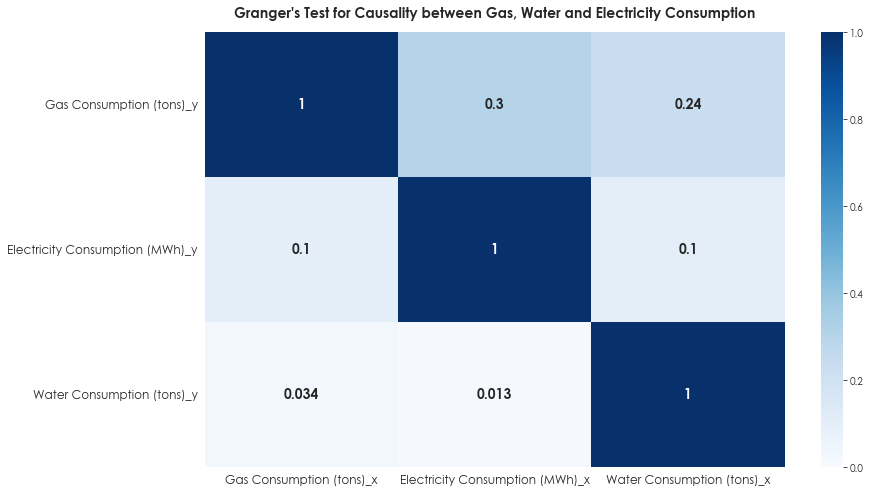

In [131]:
# Plot the heatmap to display the results
plt.figure(figsize=(13, 8))
sns.heatmap(g_matrix, annot=True, cmap="Blues", vmin=0, vmax=1, annot_kws={"size": 14, "fontweight": "bold"})

# Plot customization
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Granger's Test for Causality between Gas, Water and Electricity Consumption", y=1.02, fontsize=14, fontweight='bold')

# Display the plot
plt.show()

### GRAPH 4 : SPECTRAL DENSITY ANALYSIS OF ENERGY CONSUMPTION VARIABLES

- Based on the spectral density plot, it can be observed that the energy consumption variables (gas, water and electricity) generally demonstrate clear periodicity due to the flat portions of the plot indicating clear and consistent periodic behavior.


-  However, the spectral density plot for electricity consumption reveals the presence of a second relatively large peak around the 0.17 frequency level. This suggests an additional frequency component that contributes to the data's variability. The fluctuation associated with this secondary peak could be a signal that the electricity consumption data might not be stationary, highlighting the need for stationarity transformation to ensure more reliable analysis and modeling.

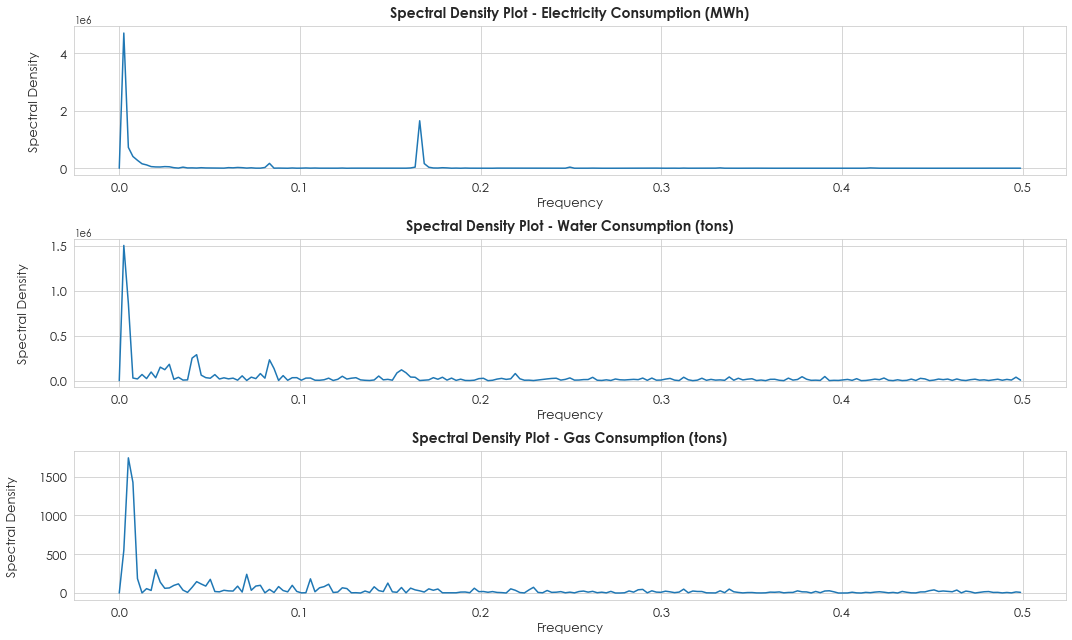

In [8]:
# Graph 4 : SPECTRAL DENSITY ANALYSIS OF ENERGY CONSUMPTION VARIABLES

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 9))

# Loop through the variables and plot the Spectral Density Plots
variables = ['Electricity Consumption (MWh)', 'Water Consumption (tons)', 'Gas Consumption (tons)']

for i, variable in enumerate(variables):
    # Compute the spectral density
    frequencies, spectral_density = signal.periodogram(energy_df_final[variable])
    
    # Plot the Spectral Density Plot in the corresponding subplot
    axes[i].plot(frequencies, spectral_density)
    axes[i].set_xlabel('Frequency', fontsize=13)
    axes[i].set_ylabel('Spectral Density', fontsize=13, labelpad=20)
    axes[i].set_title(f'Spectral Density Plot - {variable}', fontsize=14, fontweight='bold', y=1.02)
    axes[i].tick_params(axis='both', which='both', labelsize=13)

# Plot the graph
plt.tight_layout()
plt.show()

### CHECKING FOR STATIONARITY USING ADF TEST
- To check for stationarity of the time series model, use augmented Dickey-Fuller test to investigate if a unit root is present in the data.
- Obtain the ADF Test Statistic, P-Value, Number of Lags in ACF, and Critical Values.


- If the P-Value retrieved for the column is < 0.05, the data does not have a unit root and is stationary. However, if the P-Value is > 0.05, the data is not stationary in the time series evaluation.


- From the results, it is evident that only <b>Electricity Consumption (MWh) is not stationary</b> with a P-Value of 0.186 and has the highest number of lags = 15. As for the other two columns, we can conclude that the data is stationary for time series.

<b>How to interpret the P-Values :</b>

- P-value > 0.05: Fail to reject the null hypothesis (`H0`), the data has a unit root and is non-stationary.
- P-value <= 0.05: Reject the null hypothesis (`H0`), the data does not have a unit root and is stationary.


In [9]:
# Check for stationarity of the time-series model using Augmented Dickey-Fuller test

# Obtain the columns of the dataset
cols = energy_df_final.columns

# Run the Augmented Dickey-Fuller test for all the columns
print("Augmented Dickey Fuller Test for Stationarity:")
for col in cols :
    print(f"\n============================================\n\t{col}\n============================================")
    result = adfuller(energy_df_final[col])
    print("1. ADF Test Statistic:", result[0])
    print(f"2. P-Value: {result[1]:.3f}")
    print("3. Num Of Lags:", result[3])
    print("4. Critical Values:")
    
    for key, val in result[4].items():
        print("\t", key, ": ", val)

Augmented Dickey Fuller Test for Stationarity:

	Gas Consumption (tons)
1. ADF Test Statistic: -3.4043743333182737
2. P-Value: 0.011
3. Num Of Lags: 390
4. Critical Values:
	 1% :  -3.4472291365835566
	 5% :  -2.8689795375849223
	 10% :  -2.5707330834976987

	Electricity Consumption (MWh)
1. ADF Test Statistic: -2.2569805495925404
2. P-Value: 0.186
3. Num Of Lags: 381
4. Critical Values:
	 1% :  -3.4476305904172904
	 5% :  -2.869155980820355
	 10% :  -2.570827146203181

	Water Consumption (tons)
1. ADF Test Statistic: -4.684845541682444
2. P-Value: 0.000
3. Num Of Lags: 392
4. Critical Values:
	 1% :  -3.44714244478345
	 5% :  -2.8689414326247995
	 10% :  -2.5707127699396084


### MAKING THE TIME SERIES STATIONARY BY DIFFERENCING FOR ELECTRICITY

- To ensure stationarity for the electricity column, <b>first-order differencing (k_diff = 1)</b> is applied.
- The Augmented Dickey-Fuller (ADF) test is utilized to assess the effectiveness of the differencing operation and is done before and after differencing to determine stationarity.
- Using <b>.plot()</b>, generate a comparison chart to visualize the impact of differencing on the electricity consumption time series.

Results Obtained from Differencing :
- After differencing, the p-value for 'Electricity Consumption (MWh)' is now 0, indicating that first-order differencing is sufficient to make the data in electricity consumption stationary.
- From the differenced plot, we also see that applying first-order differencing has eliminated any trends and irregularities from the electricity consumption data, and is ready for time series analysis.

Electricity Consumption (MWh) before differencing p-value: 0.186218
Electricity Consumption (MWh) after differencing p-value: 0.000000


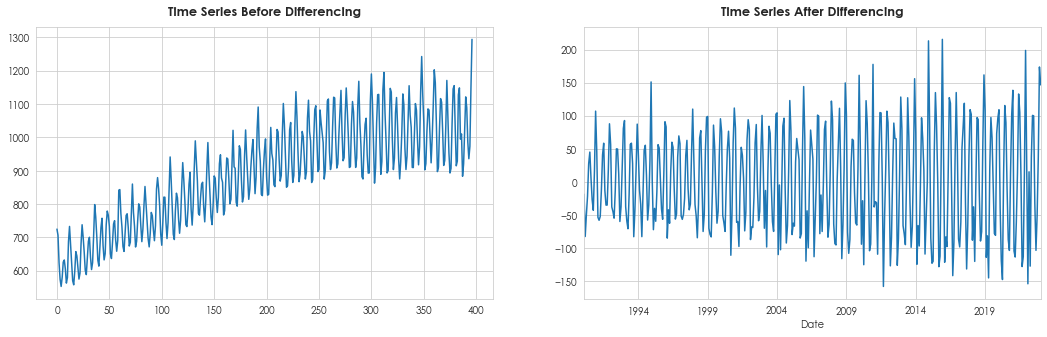

In [10]:
# Make the time series stationary by differencing for the Electricity Consumption

# Perform differencing operation
energy_df_diff = diff(energy_df_final['Electricity Consumption (MWh)'], k_diff = 1)

# Perform ADF test before and after differencing
result1 = adfuller(energy_df_final['Electricity Consumption (MWh)'])
result2 = adfuller(energy_df_diff)
print('Electricity Consumption (MWh) before differencing p-value: %f' % result1[1])
print('Electricity Consumption (MWh) after differencing p-value: %f' % result2[1])

# Plot the time series before and after differencing
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
energy_df['Electricity Consumption (MWh)'].plot(ax=ax[0])
energy_df_diff.plot(ax=ax[1])
ax[0].set_title('Time Series Before Differencing', fontweight='bold', fontsize=13, y=1.02)
ax[1].set_title('Time Series After Differencing', fontweight='bold', fontsize=13, y=1.02)

# Display the plots
plt.show()

### SPLITTING AND TRAINING OF ENERGY CONSUMPTION DATASET

- Split the dataset into training, validation and test set, which is essential for the effective development and evaluation of predictive models.
- 70% of the data is allocated to training, 15% for validation, and 15% for the test set to predict on unseen test data.


- Number of rows for each set is computed based on the total length of the dataset and <b>math.ceil()</b> is used to ensure each set has an appropriate number of rows.


Splitting of the Data :

- Train Data: Consisting of the initial rows up to the calculated train_rows.
- Validation Data: Spanning from train_rows to train_rows + validation_rows.
- Test Data: Encompassing the remaining rows after training and validation sets.

In [132]:
# Splitting and Training of Time Series Data

# Define the proportion of data for each set
train_ratio = 0.7  
validation_ratio = 0.15  
test_ratio = 1 - train_ratio - validation_ratio

# Calculate the number of rows for each set
train_rows = math.ceil(train_ratio * len(energy_df_final))
validation_rows = math.ceil(validation_ratio * len(energy_df_final))
test_rows = len(energy_df_final) - train_rows - validation_rows

# Split the data into training, validation, and test sets
train_data = energy_df_final.iloc[:train_rows]
validation_data = energy_df_final.iloc[train_rows:train_rows+validation_rows]
test_data = energy_df_final.iloc[train_rows+validation_rows:train_rows+validation_rows+test_rows]

# Print the shape of the sets to validate
print("Number of Rows and Columns for Training, Validation and Test Data:\n")
print(f"Training Data: {train_data.shape}")
print(f"Validation Data: {validation_data.shape}")
print(f"Testing Data: {test_data.shape}")

Number of Rows and Columns for Training, Validation and Test Data:

Training Data: (278, 3)
Validation Data: (60, 3)
Testing Data: (59, 3)


### TESTING FORECASTING TIME SERIES MODELS ON DIFFERENT ENERGY CONSUMPTION TYPES

For Gas, Electricity and Water Energy Consumption, 3 models were implemented for analysis : 
- Holt Winter's Exponential Smoothing Model
- ARIMA Time Series Model 
- SARIMA Time Series Model

### <font color='green'> CONSUMPTION TYPE 1 : GAS CONSUMPTION (TONS)</font>

### OBTAIN THE AUTOCORRELATION AND PARTIAL AUTOCORRELATION PLOTS

ACF Plot : The ACF plot shows the correlation between a time series and its lags, determining the order of MA(q) process.

- From the ACF plot, it has two significant spikes at lag1 and lag2, indicating that an MA(2) process is suitable for gas consumption data.

PACF Plot : The Partial Autocorrelation Function (PACF) plot helps identify the direct effect of one lag on the current observation, determining the order of AR(p) process.

- From the PACF plot, it has one significant spike at lag1, indicating that an AR(1) process is suitable for gas consumption data.

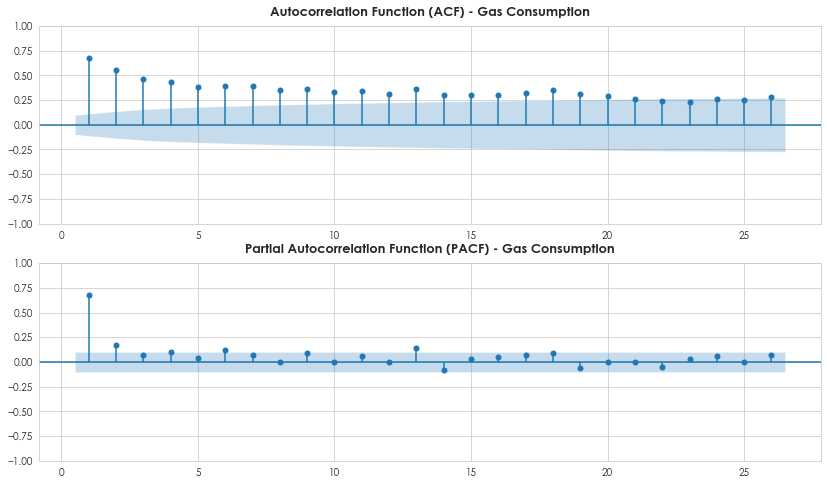

In [97]:
# Plotting the ACF and PACF plots for Gas Consumption

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Create the figure axes
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,8))

# Plot the ACF for Gas Consumption
plot_acf(energy_df_final['Gas Consumption (tons)'], zero=False, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) - Gas Consumption', fontsize=13, fontweight='bold', y=1.02)

# Plot the PACF for Gas Consumption
plot_pacf(energy_df_final['Gas Consumption (tons)'], zero=False, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) - Gas Consumption', fontsize=13, fontweight='bold', y=1.02)

plt.show()

### INVESTIGATE SEASONALITY USING THE SEASONAL DECOMPOSITION PLOT

- To determine seasonality, use the 'seasonal_decompose' function to plot the seasonal decomposition plot.
- Specify model as 'additive' as it is seen that seasonal fluctuations do not vary significantly as gas consumption levels change, and the patterns in seasonality is the same throughout.


- Under 'seasonal' in the plot, we can see that there is seasonality in gas consumption due to the regular, consistent fluctuations occuring between 1990 to 2023.
- Under 'resid' in the plot, the residuals appear to follow a random pattern and are relatively evenly distributed around zero, indicating that the model can capture all relevant features of the data.

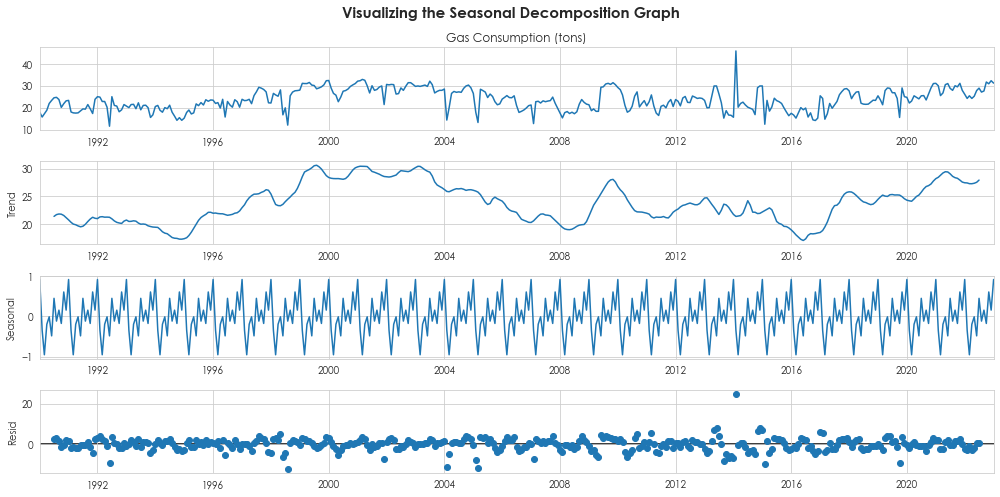

In [159]:
# Plot the seasonal decomposition graph to investigate seasonality

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Perform seasonal decomposition
gas_decomp = seasonal_decompose(energy_df_final['Gas Consumption (tons)'], model='additive')

# Plot the decomposition graph
fig = gas_decomp.plot()
fig.set_size_inches((14,7))

# Create a title with a larger font size
title = fig.suptitle('Visualizing the Seasonal Decomposition Graph', x=0.51, fontweight='bold')
title.set_fontsize(15)

# Display the figure
plt.tight_layout()
plt.show()

### DETERMINE SEASONAL PERIOD USING SEASONAL AUTOCORRELATION PLOT

- Using the seasonal decomposition graph, plot a seasonal ACF plot to determine the seasonal period for gas consumption.
- Significant spikes extending beyond the significance bands indicate the presence of seasonal patterns.
- From the plot, it is clear that the spike occurs at the period 12, indicating that the seasonal period for gas consumption is likely to be 12.

Seasonal Period for Gas Consumption : 12


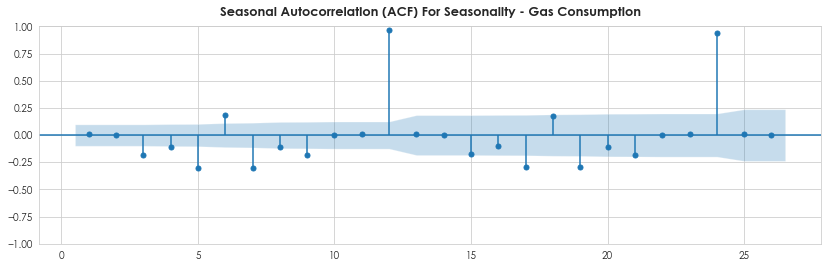

In [106]:
# Plotting the autocorrelation plot to determine seasonal period

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Create the figure axes
fig, (ax1) = plt.subplots(1,1, figsize=(14,4))

plot_acf(gas_decomp.seasonal, zero=False, ax=ax1)
ax1.set_title('Seasonal Autocorrelation (ACF) For Seasonality - Gas Consumption', fontsize=13, y=1.02, fontweight='bold')
print("Seasonal Period for Gas Consumption :", len(gas_decomp.seasonal.drop_duplicates()))
plt.show()

### CROSS-VALIDATION OF MODELS FOR GAS CONSUMPTION (TONS)

- Compare the performance of different models using time series cross-validation where cv folds = 5.
- Obtain the mean average percentage error, mean squared error and root mean squared error for each model and retrieve the results. 
- The lower the metric values, the better the model for time series prediction.
- From the cross-validation, it is clear that the <b>SARIMA Model</b> provides the lowest error rate of <b>0.1929 for MAPE</b>.

In [163]:
# Perform Cross-Validation on Models for Gas Consumption (tons)

# Initialise and store the error metrics in lists
mape_scores_exp = []
mse_scores_exp = []
rmse_scores_exp = []

mape_scores_arima = []
mse_scores_arima = []
rmse_scores_arima = []

mape_scores_sarima = []
mse_scores_sarima = []
rmse_scores_sarima = []

# Perform time series cross validation for gas consumption in tons
tscv = TimeSeriesSplit(n_splits=5)

# Indexing for training and testing set in the data
for train_idx, test_idx in tscv.split(energy_df_final):
    cv_train_gas = energy_df_final.iloc[train_idx]
    cv_test_gas = energy_df_final.iloc[test_idx]
    
    # Exponential Smoothing Holt Winters
    hwes_model = ExponentialSmoothing(cv_train_gas['Gas Consumption (tons)'], trend='add', seasonal='add', seasonal_periods=12)
    hwes_fit = hwes_model.fit()
    hwes_predict = hwes_fit.predict(start=cv_test_gas.index[0], end=cv_test_gas.index[-1])
    
    # ARIMA Model
    arima_model = SARIMAX(cv_train_gas['Gas Consumption (tons)'], order=(1,0,2))
    arima_fit = arima_model.fit(disp=False)
    arima_predict = arima_fit.predict(start=cv_test_gas.index[0], end=cv_test_gas.index[-1])
    
    # SARIMA Model
    sarima_model = SARIMAX(cv_train_gas['Gas Consumption (tons)'], order=(1,0,2), seasonal_order=(2,1,5,12))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_predict= sarima_fit.predict(start=cv_test_gas.index[0], end=cv_test_gas.index[-1])
    
    # Calculate error metrics for Exponential Smoothing
    mape_scores_exp.append(mean_absolute_error(cv_test_gas['Gas Consumption (tons)'], hwes_predict) / cv_test_gas['Gas Consumption (tons)'])
    mse_scores_exp.append(mean_squared_error(cv_test_gas['Gas Consumption (tons)'], hwes_predict))
    rmse_scores_exp.append(np.sqrt(mean_squared_error(cv_test_gas['Gas Consumption (tons)'], hwes_predict)))
    
    # Calculate error metrics for ARIMA
    mape_scores_arima.append(mean_absolute_error(cv_test_gas['Gas Consumption (tons)'], arima_predict) / cv_test_gas['Gas Consumption (tons)'])
    mse_scores_arima.append(mean_squared_error(cv_test_gas['Gas Consumption (tons)'], arima_predict))
    rmse_scores_arima.append(np.sqrt(mean_squared_error(cv_test_gas['Gas Consumption (tons)'], arima_predict)))
    
    # Calculate error metrics for SARIMA
    mape_scores_sarima.append(mean_absolute_error(cv_test_gas['Gas Consumption (tons)'], sarima_predict) / cv_test_gas['Gas Consumption (tons)'])
    mse_scores_sarima.append(mean_squared_error(cv_test_gas['Gas Consumption (tons)'], sarima_predict))
    rmse_scores_sarima.append(np.sqrt(mean_squared_error(cv_test_gas['Gas Consumption (tons)'], sarima_predict)))
    
# Calculate average error rates for each metric for Exponential Smoothing
average_mape_exp = np.mean(mape_scores_exp)
average_mse_exp = np.mean(mse_scores_exp)
average_rmse_exp = np.mean(rmse_scores_exp)

# Calculate average error rates for each metric for ARIMA
average_mape_arima = np.mean(mape_scores_arima)
average_mse_arima = np.mean(mse_scores_arima)
average_rmse_arima = np.mean(rmse_scores_arima)

# Calculate average error rates for each metric for SARIMA
average_mape_sarima = np.mean(mape_scores_sarima)
average_mse_sarima = np.mean(mse_scores_sarima)
average_rmse_sarima = np.mean(rmse_scores_sarima)
    
# Display the results
print("Cross-Validation Evaluation Metrics for Gas Consumption (tons):\n")

# Print the results for Exponential Smoothing
print("Exponential Smoothing for Gas Consumption (tons):")
print(f"Average MAPE: {average_mape_exp:.4f}")
print(f"Average MSE: {average_mse_exp:.4f}")
print(f"Average RMSE: {average_rmse_exp:.4f}\n")

# Print the results for ARIMA
print("ARIMA for Gas Consumption (tons):")
print(f"Average MAPE: {average_mape_arima:.4f}")
print(f"Average MSE: {average_mse_arima:.4f}")
print(f"Average RMSE: {average_rmse_arima:.4f}\n")

# Print the results for SARIMA
print("SARIMA for Gas Consumption (tons):")
print(f"Average MAPE: {average_mape_sarima:.4f}")
print(f"Average MSE: {average_mse_sarima:.4f}")
print(f"Average RMSE: {average_rmse_sarima:.4f}")

Cross-Validation Evaluation Metrics for Gas Consumption (tons):

Exponential Smoothing for Gas Consumption (tons):
Average MAPE: 0.2245
Average MSE: 44.0702
Average RMSE: 6.4481

ARIMA for Gas Consumption (tons):
Average MAPE: 0.2054
Average MSE: 39.3771
Average RMSE: 5.9795

SARIMA for Gas Consumption (tons):
Average MAPE: 0.1929
Average MSE: 32.4476
Average RMSE: 5.5570


### CROSS-VALIDATION OF THE PREDICTION PLOTS FOR THE VARIOUS MODELS

- Create a subplot grid to display the actual vs. predicted gas consumption values for each model in each of the 5 folds.

- Fit and predict the training data to the respective models using .fit() and .predict(), and plot the relevant plots for each model.

- From the plots, it is clear that the predicted values (in orange) for the SARIMA Model is best fitted to follow the trend of the original data, hence supporting the decision to choose SARIMA Model as the final model for time series forecasting of gas consumption.

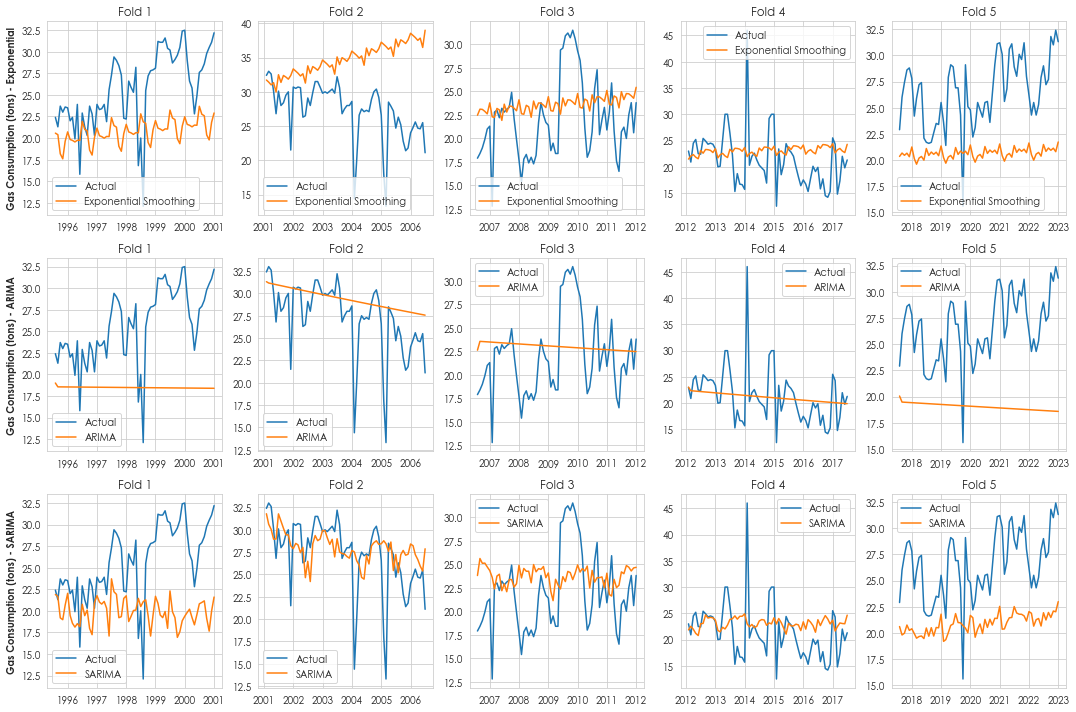

In [164]:
# Perform Cross-Validation of the plots on 5 folds for all the models

# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Set the style and font for the plots
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Create a 3x5 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))

# Define the model names
model_names = ['Exponential Smoothing', 'ARIMA', 'SARIMA']

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(tscv.split(energy_df_final), start=1):
    cv_train_gas = energy_df_final.iloc[train_index]
    cv_test_gas = energy_df_final.iloc[test_index]

    # Exponential Smoothing Holt Winters
    hwes_model = ExponentialSmoothing(cv_train_gas['Gas Consumption (tons)'], trend='add', seasonal='add', seasonal_periods=12)
    hwes_fit = hwes_model.fit()
    hwes_predict = hwes_fit.predict(start=cv_test_gas.index[0], end=cv_test_gas.index[-1])
    
    # ARIMA Model
    arima_model = SARIMAX(cv_train_gas['Gas Consumption (tons)'], order=(1,0,2))
    arima_fit = arima_model.fit(disp=False)
    arima_predict = arima_fit.predict(start=cv_test_gas.index[0], end=cv_test_gas.index[-1])
    
    # SARIMA Model
    sarima_model = SARIMAX(cv_train_gas['Gas Consumption (tons)'], order=(1,0,2), seasonal_order=(2,1,5,12))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_predict= sarima_fit.predict(start=cv_test_gas.index[0], end=cv_test_gas.index[-1])
    
    # Plot actual vs. predicted values for each model
    for model_idx, (model_name, predict_values) in enumerate(zip(model_names, [hwes_predict, arima_predict, sarima_predict])):
        axes[model_idx, fold-1].plot(cv_test_gas.index, cv_test_gas['Gas Consumption (tons)'], label='Actual')
        axes[model_idx, fold-1].plot(cv_test_gas.index, predict_values, label=model_name)
        axes[model_idx, fold-1].set_title(f"Fold {fold}")
        axes[model_idx, fold-1].legend()

# Set common y-axis labels for each row
axes[0, 0].set_ylabel('Gas Consumption (tons) - Exponential', fontweight='bold')
axes[1, 0].set_ylabel('Gas Consumption (tons) - ARIMA', fontweight='bold')
axes[2, 0].set_ylabel('Gas Consumption (tons) - SARIMA', fontweight='bold')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### PLOTTING LAG PLOTS TO DETERMINE AUTOCORRELATION

To identify any recurring patterns or dependencies within the data for gas consumption, lag plots are plotted using lag_plot to visualise the relationship between a data point and its lagged counterpart at a specified time interval.

Based on the lag plots, at y(t+1) to y(t+4), there seems to be a positive correlation in the plots, indicating that past values of the time series does have an influence on its future values. Furthermore, repeated correlations at regular intervals of 12 indicate that data contains seasonality, showing seasonal correlations, further supporting the need to use the SARIMA Model for evaluation.

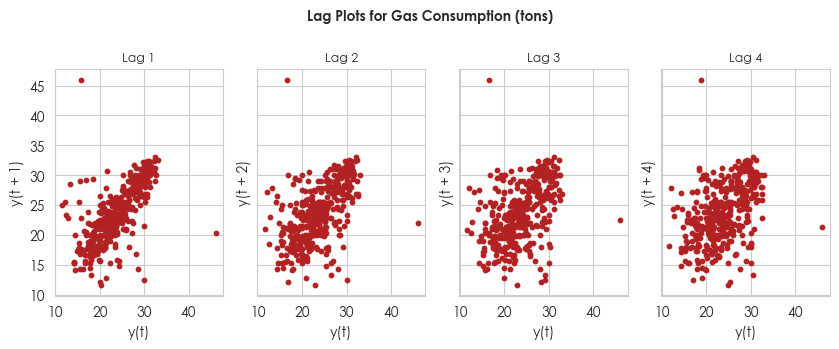

In [102]:
# Plot the lag plots for gas consumption

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Create a figure and a grid of subplots for lag plots
fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True, dpi=100)

# Loop through lag values and create lag plots
for i, ax in enumerate(axes.flatten()[:4]):
   
    # Generate a lag plot for 'Gas Consumption (tons)' time series data
    lag_plot(energy_df_final['Gas Consumption (tons)'], lag=i + 1, ax=ax, c='firebrick', s=10)
    
    # Set the title for the current lag plot
    ax.set_title('Lag ' + str(i + 1), fontsize=9)

# Set a super title for the entire figure
fig.suptitle('Lag Plots for Gas Consumption (tons)', y=1.08, fontweight='bold', fontsize=10)

# Display the lag plots
plt.show()

### EVALUATION OF THE SARIMA MODEL FOR GAS CONSUMPTION (TONS)

### INITIALIZING AND FINETUNING THE SARIMA MODEL FOR GAS CONSUMPTION (TONS)

- To improve the forecasting accuracy of the SARIMA model for gas consumption, hyperparameters need to be optimized.
- Store the parameters into ranges and loop through the parameters.
- Fit the best parameters to the model for training and testing.

Parameters Used:
- `p_range`: The order of the autoregressive (AR) component, which captures the dependence on past observations.
- `d_range`: The order of differencing, which helps achieve stationarity by removing trends.
- `q_range`: The order of the moving average (MA) component, which accounts for the influence of past error terms.
- `seasonal`: The order of the seasonal autoregressive (SAR) component, capturing seasonality patterns.
- `p1_range`: The order of the seasonal autoregressive (SAR) component for seasonal differencing.
- `d1_range`: The order of seasonal differencing to achieve stationarity.
- `q1_range`: The order of the seasonal moving average (SMA) component, accounting for seasonal errors.

Summary Table Ranking the Parameters Contains:
- `p`, `d`, `q`: The orders of AR, differencing, and MA components.
- `p1`, `d1`, `q1`, `r`: The orders of seasonal AR, seasonal differencing, seasonal MA components, and the seasonal period.
- `MAPE`, `MSE`, `RMSE`: Forecast accuracy metrics.
- `AIC`, `BIC`: Information criteria indicating model goodness-of-fit.

<b>Sort the values in the table according to AIC (ascending) as the main goal of the analysis is to identify good predictive models, which AIC helps achieve.</b>

In [139]:
# Tuning the hyperparameters for Gas Consumption (tons) using SARIMA Model

# Specify the ranges for the parameter values
p_range = range(1, 4) # Order of the autoregressive (AR) component
d_range = [0] # Order of differencing - differencing is not needed for gas consumption
q_range = range(1, 3) # Order of moving average (MA) component
seasonal = [12] # Order of seasonal autoregressive (SAR) component
p1_range = range(1, 4) # Order of seasonal autoregressive (SAR) component for seasonal differencing
d1_range = range(0, 2) # Order of seasonal differencing
q1_range = range(1, 6) # Order of seasonal moving average (SMA) component

# Store the results into an array
gas_results = []

# Loop through the parameter combinations to find the best parameters
for p in p_range:
    for d in d_range:
        for q in q_range:
            for r in seasonal:
                for p1 in p1_range:
                    for d1 in d1_range:
                        for q1 in q1_range:
                            # Create and fit the SARIMA(p,d,q) model
                            gas_model = SARIMAX(train_data['Gas Consumption (tons)'], order = (p,d,q), seasonal_order = (p1,d1,q1,r), enforce_stationarity=False)
                            # Fit SARIMA model to the model
                            sarima_tuned = gas_model.fit()
                            
                            # Make a SARIMA forecast 
                            sarima_forecast = sarima_tuned.get_forecast(steps=60).predicted_mean
                            
                            # Obtain evaluation metrics using validation data
                            mape = round(mean_absolute_percentage_error(validation_data['Gas Consumption (tons)'], sarima_forecast)*100,3)
                            mse = round(mean_squared_error(validation_data['Gas Consumption (tons)'], sarima_forecast),3)
                            rmse = round(np.sqrt(mse),3)

                            gas_results.append((p, d, q, p1, d1, q1, r, mape, mse, rmse, sarima_tuned.aic, sarima_tuned.bic))
                            
# Construct a dataframe to store the values from the tuning
order_gas = pd.DataFrame(gas_results, columns=['p','d','q','p1','d1','q1','r','MAPE','MSE', 'RMSE', 'AIC', 'BIC'])

# Print order_gas in order of increasing AIC
aic_order = order_gas.sort_values('AIC')

# Display the dataframe of results
print('Summary Table for Gas Consumption (tons) Seasonal Order (SARIMA) :')
aic_order

Summary Table for Gas Consumption (tons) Seasonal Order (SARIMA) :


,p,d,q,p1,d1,q1,r,MAPE,MSE,RMSE,AIC,BIC
99,2,0,2,1,1,5,12,25.986,40.854,6.392,1059.695227,1096.140493
109,2,0,2,2,1,5,12,26.273,39.502,6.285,1060.665317,1100.423788
49,1,0,2,2,1,5,12,25.661,38.138,6.176,1062.334580,1098.779845
69,2,0,1,1,1,5,12,26.084,40.212,6.341,1062.428318,1095.609518
59,1,0,2,3,1,5,12,25.670,38.828,6.231,1062.732709,1102.491180
...,...,...,...,...,...,...,...,...,...,...,...,...
150,3,0,2,1,0,1,12,22.810,33.560,5.793,1337.443708,1366.020940
90,2,0,2,1,0,1,12,23.768,34.977,5.914,1337.690550,1362.695629
60,2,0,1,1,0,1,12,22.700,33.361,5.776,1338.135843,1359.591537
30,1,0,2,1,0,1,12,20.385,31.294,5.594,1343.509154,1364.942078


### RETRIEVE TOP 5 RESULTS FOR MODEL EVALUATION SORTED BY RMSE, MAPE AND AIC

- Sort the tuned results in the dataframe by RMSE, MAPE and AIC.
- BIC is not used to sort the data as it is more important to identify good predictive models in this analysis.
- Based on the results obtained, determine the best order and seasonal order configuration for predicting gas consumption.

In [140]:
# Obtaining the top 5 results for model evaluation sorted by RMSE, MAPE and AIC

# Sort the table by order of RMSE, MAPE, and AIC
ordergas_rmse = order_gas.sort_values('RMSE').head()
ordergas_mape = order_gas.sort_values('MAPE').head()
ordergas_aic = order_gas.sort_values('AIC').head()

# Add labels to indicate the segments
ordergas_rmse['Segment'] = 'Best RMSE'
ordergas_mape['Segment'] = 'Best MAPE'
ordergas_aic['Segment'] = 'Best AIC'

# Create separate dataframes for each segment
summarytable_rmse = ordergas_rmse[['Segment', 'p', 'd', 'q', 'p1', 'd1', 'q1', 'r', 'MAPE', 'MSE', 'RMSE', 'AIC']]
summarytable_mape = ordergas_mape[['Segment', 'p', 'd', 'q', 'p1', 'd1', 'q1', 'r', 'MAPE', 'MSE', 'RMSE', 'AIC']]
summarytable_aic = ordergas_aic[['Segment', 'p', 'd', 'q', 'p1', 'd1', 'q1', 'r', 'MAPE', 'MSE', 'RMSE', 'AIC']]

# Sort each summarytable dataframe by the corresponding metric (RMSE, MAPE, AIC)
summarytable_rmse['Segment'] = pd.Categorical(summarytable_rmse['Segment'], ordered=True)
summarytable_rmse = summarytable_rmse.sort_values(by=['RMSE'], ascending=True)

summarytable_mape['Segment'] = pd.Categorical(summarytable_mape['Segment'], ordered=True)
summarytable_mape = summarytable_mape.sort_values(by=['MAPE'], ascending=True)

summarytable_aic['Segment'] = pd.Categorical(summarytable_aic['Segment'], ordered=True)
summarytable_aic = summarytable_aic.sort_values(by=['AIC'], ascending=True)

# Display the summarytables
print("Summary Table for Gas Consumption (tons) Seasonal Order (SARIMA) - Best MAPE:")
print(summarytable_mape)

print("\nSummary Table for Gas Consumption (tons) Seasonal Order (SARIMA) - Best RMSE:")
print(summarytable_rmse)

print("\nSummary Table for Gas Consumption (tons) Seasonal Order (SARIMA) - Best AIC:")
print(summarytable_aic)

Summary Table for Gas Consumption (tons) Seasonal Order (SARIMA) - Best MAPE:
       Segment  p  d  q  p1  d1  q1   r    MAPE     MSE   RMSE          AIC
164  Best MAPE  3  0  2   2   0   5  12  18.668  39.705  6.301  1114.551255
104  Best MAPE  2  0  2   2   0   5  12  18.691  36.797  6.066  1114.158641
74   Best MAPE  2  0  1   2   0   5  12  18.774  40.757  6.384  1114.315723
132  Best MAPE  3  0  1   2   0   3  12  18.925  37.300  6.107  1223.756742
154  Best MAPE  3  0  2   1   0   5  12  18.946  36.564  6.047  1115.144342

Summary Table for Gas Consumption (tons) Seasonal Order (SARIMA) - Best RMSE:
       Segment  p  d  q  p1  d1  q1   r    MAPE     MSE   RMSE          AIC
30   Best RMSE  1  0  2   1   0   1  12  20.385  31.294  5.594  1343.509154
50   Best RMSE  1  0  2   3   0   1  12  20.627  31.419  5.605  1224.522495
131  Best RMSE  3  0  1   2   0   2  12  19.995  31.435  5.607  1288.213887
32   Best RMSE  1  0  2   1   0   3  12  19.908  31.542  5.616  1218.440547
140  Be

### RE-FITTING THE SARIMA MODEL WITH HYPERPARAMETERS

- Initialize and fit the SARIMA Model using .fit() and specify the order and seasonal order.
- Obtain evaluation metrics on the testing set and generate the diagnostics plots for the model.

                                            SARIMAX Results                                             
Dep. Variable:                           Gas Consumption (tons)   No. Observations:                  278
Model:             SARIMAX(2, 0, 2)x(1, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                -518.848
Date:                                          Fri, 11 Aug 2023   AIC                           1059.695
Time:                                                  22:15:44   BIC                           1096.140
Sample:                                              01-01-1990   HQIC                          1074.440
                                                   - 02-01-2013                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

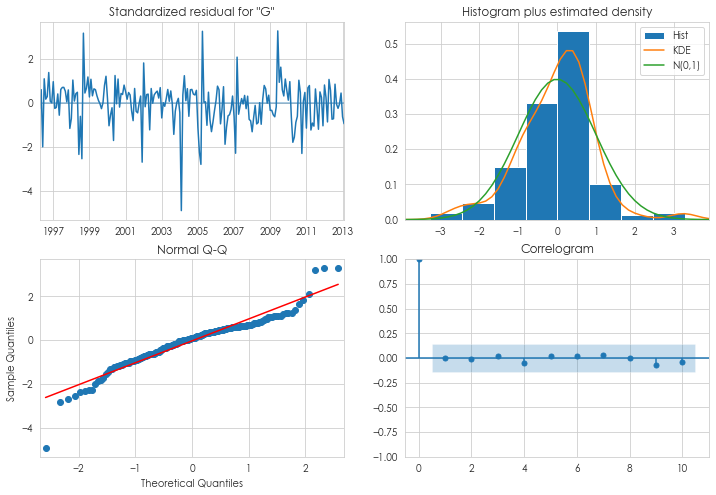

In [225]:
# Refitting the SARIMA Model with tuned values

# Define the SARIMA Model
model_gas = SARIMAX(train_data['Gas Consumption (tons)'], order=(2,0,2), enforce_stationarity = False, seasonal_order=(1,1,5,12))

# Fit the SARIMA model
sarima_tuned = model_gas.fit()
# Print the summary of the results
print(sarima_tuned.summary())

# Make an SARIMA forecast
sarima_forecast = sarima_tuned.get_forecast(steps=59).predicted_mean

# Obtain evaluation metrics from SARIMA
mape = mean_absolute_percentage_error(test_data['Gas Consumption (tons)'], sarima_forecast)*100
mse = mean_squared_error(test_data['Gas Consumption (tons)'], sarima_forecast)
rmse = np.sqrt(mse)

# Printing the evaluation metrics 
print("\n=================================================================\n\tEvaluation Metrics for Gas Consumption (tons)\n=================================================================")
print("MAPE on Test Data:", mape)
print("MSE on Test Data:", mse)
print("RMSE on Test Data:", rmse, "\n")

# Create the 4 diagostics plots
sarima_tuned.plot_diagnostics(figsize=(12,8))
plt.show()

### VISUALIZING THE FINAL FORECAST VALUES OF GAS CONSUMPTION

- Generate predictions using the tuned SARIMA model for the specified time range from 1990 to 2023.
- Plot the training and testing data and predict on the training data using .get_prediction.
- Generate forecast (future) values for the next 59 periods and set the frequency of the data to 'M' (monthly).

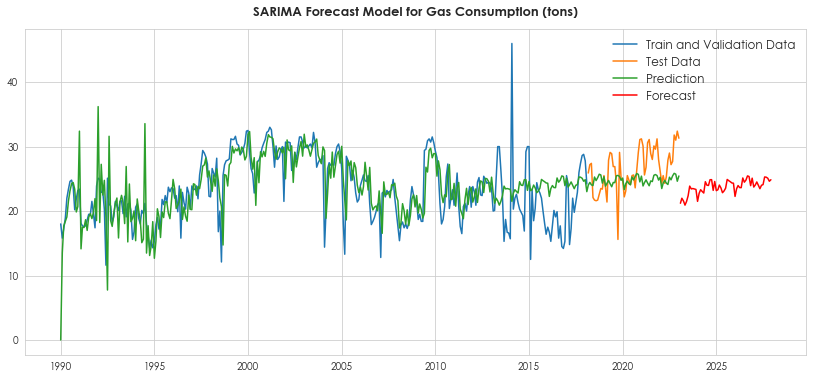

In [226]:
# Plotting the tuned SARIMA graph for Gas Consumption

# Generate predictions using the tuned SARIMA model for the specified time range
gas_pred = sarima_tuned.get_prediction(start='1990-01-01', end='2023-01-01').predicted_mean

# Create a new figure and axis for the plot, specifying the size
fig, ax = plt.subplots(figsize=(14, 6))

# Plot the actual training, validation, and test data, as well as the prediction
ax.plot(pd.concat([train_data['Gas Consumption (tons)'], validation_data['Gas Consumption (tons)']]), label='Train and Validation Data')
ax.plot(test_data['Gas Consumption (tons)'], label='Test Data')
ax.plot(gas_pred, label='Prediction')

# Generate forecast values
sarima_forecast = sarima_tuned.get_forecast(steps=59).predicted_mean

# Plot the forecasted future values
forecast_values = pd.date_range(start='2023-01-02', periods=59, freq='M')  # Adjust the date range and frequency
ax.plot(forecast_values, sarima_forecast, label='Forecast', color='red')

# Add legend to the plot
plt.legend(frameon=False, fontsize=12)

# Setting the title to the plot
plt.title('SARIMA Forecast Model for Gas Consumption (tons)', fontsize=13, fontweight='bold', y=1.02)

# Display the plot
plt.show()

### <font color='green'> CONSUMPTION TYPE 2 : WATER CONSUMPTION (TONS)</font>

### OBTAIN THE AUTOCORRELATION AND PARTIAL AUTOCORRELATION PLOTS

- From the ACF plot, it has two significant spikes at lag1 and lag2, indicating that an MA(2) process is suitable for water consumption data.


- From the PACF plot, it has one significant spike at lag1, indicating that an AR(1) process is suitable for water consumption data.

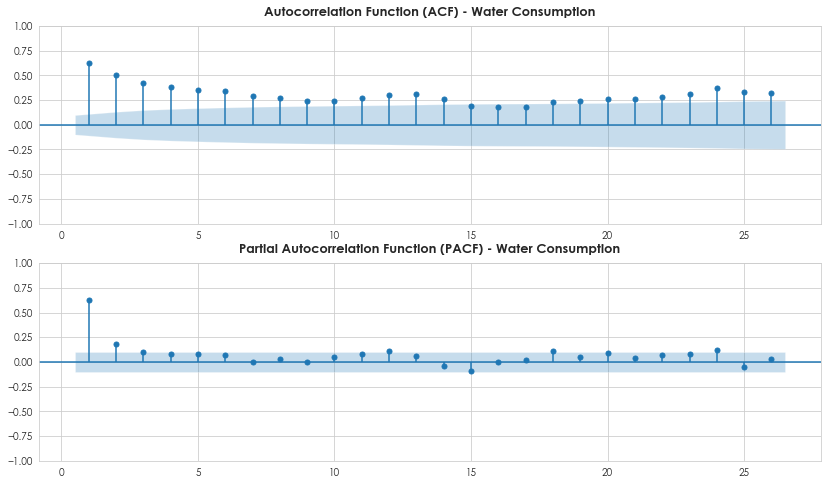

In [152]:
# Plotting the ACF and PACF plots for Water Consumption

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Create the figure axes
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,8))

# Plot the ACF for Water Consumption
plot_acf(energy_df_final['Water Consumption (tons)'], zero=False, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) - Water Consumption', fontsize=13, fontweight='bold', y=1.02)

# Plot the PACF for Water Consumption
plot_pacf(energy_df_final['Water Consumption (tons)'], zero=False, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) - Water Consumption', fontsize=13, fontweight='bold', y=1.02)

plt.show()

### INVESTIGATE SEASONALITY USING THE SEASONAL DECOMPOSITION PLOT

- To determine seasonality, use the 'seasonal_decompose' function to plot the seasonal decomposition plot.
- Specify model as 'additive' as it is seen that seasonal fluctuations do not vary significantly as water consumption levels change, and the patterns in seasonality is the same throughout.


- Under 'seasonal' in the plot, we can see that there is seasonality in water consumption due to the regular, consistent fluctuations occuring between 1990 to 2023.
- Under 'resid' in the plot, the residuals appear to follow a random pattern with a few outliers further away from zero, hence it is necessary to perform hyperparameter tuning to improve the performance of the model.

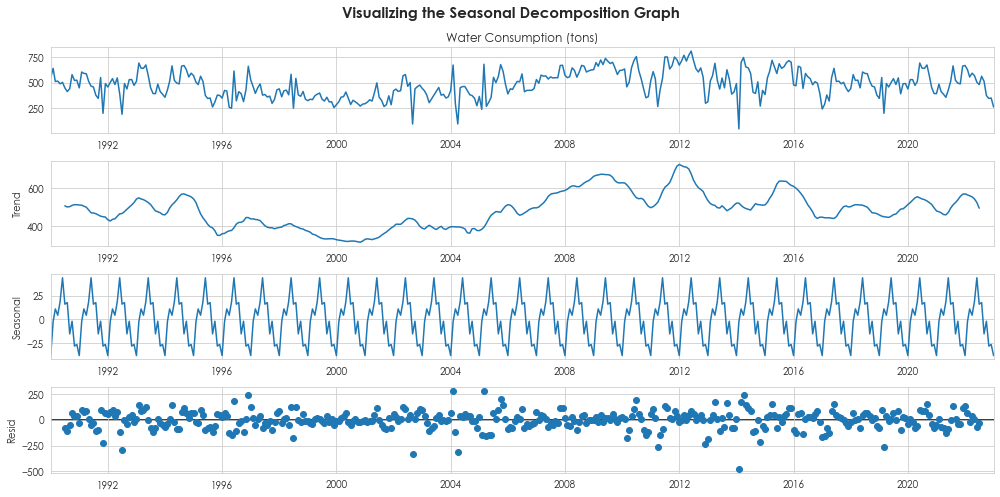

In [72]:
# Plot the seasonal decomposition graph to investigate seasonality

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Perform seasonal decomposition
water_decomp = seasonal_decompose(energy_df_final['Water Consumption (tons)'], model='additive')

# Plot the decomposition graph
fig = water_decomp.plot()
fig.set_size_inches((14,7))

# Create a title with a larger font size
title = fig.suptitle('Visualizing the Seasonal Decomposition Graph', x=0.51, fontweight='bold')
title.set_fontsize(15)

# Display the figure
plt.tight_layout()
plt.show()

### DETERMINE SEASONAL PERIOD USING SEASONAL AUTOCORRELATION PLOT

- Using the seasonal decomposition graph, plot a seasonal ACF plot to determine the seasonal period for water consumption.
- Significant spikes extending beyond the significance bands indicate the presence of seasonal patterns.
- From the plot, it is clear that the spike occurs at the period 12, indicating that the seasonal period for water consumption is likely to be 12.

Seasonal Period for Water Consumption : 12


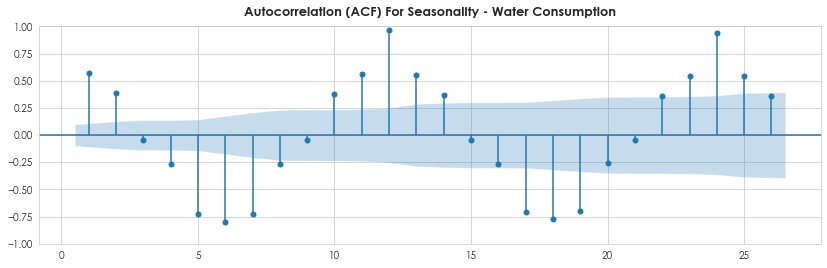

In [170]:
# Plotting the autocorrelation plot to determine seasonal period

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Create the figure axes
fig, (ax1) = plt.subplots(1,1, figsize=(14,4))

plot_acf(water_decomp.seasonal, zero=False, ax=ax1)
ax1.set_title('Autocorrelation (ACF) For Seasonality - Water Consumption', fontsize=13, y=1.02, fontweight='bold')
print("Seasonal Period for Water Consumption :", len(water_decomp.seasonal.drop_duplicates()))
plt.show()

### CROSS-VALIDATION OF MODELS FOR WATER CONSUMPTION (TONS)

- Compare the performance of different models using time series cross-validation where cv folds = 5.
- Obtain the mean average percentage error, mean squared error and root mean squared error for each model and retrieve the results. 
- The lower the metric values, the better the model for time series prediction.
- From the cross-validation, it is clear that the <b>SARIMA Model</b> provides the lowest error rate of <b>0.2804 for MAPE</b>.

In [176]:
# Perform Cross-Validation on Models for Gas Consumption (tons)

# Initialise and store the error metrics in lists
mape_scores_exp = []
mse_scores_exp = []
rmse_scores_exp = []

mape_scores_arima = []
mse_scores_arima = []
rmse_scores_arima = []

mape_scores_sarima = []
mse_scores_sarima = []
rmse_scores_sarima = []

# Perform time series cross validation for water consumption in tons
tscv = TimeSeriesSplit(n_splits=5)

# Indexing for training and validation set in the data
for train_idx, test_idx in tscv.split(energy_df_final):
    cv_train_water = energy_df_final.iloc[train_idx]
    cv_test_water = energy_df_final.iloc[test_idx]
    
    # Exponential Smoothing Holt Winters
    hwes_model = ExponentialSmoothing(cv_train_water['Water Consumption (tons)'], trend='add', seasonal='add', seasonal_periods=12)
    hwes_fit = hwes_model.fit()
    hwes_predict = hwes_fit.predict(start=cv_test_water.index[0], end=cv_test_water.index[-1])
    
    # ARIMA Model
    arima_model = SARIMAX(cv_train_water['Water Consumption (tons)'], order=(2,0,1))
    arima_fit = arima_model.fit(disp=False)
    arima_predict = arima_fit.predict(start=cv_test_water.index[0], end=cv_test_water.index[-1])
    
    # SARIMA Model
    sarima_model = SARIMAX(cv_train_water['Water Consumption (tons)'], order=(2,0,1), seasonal_order=(2,0,1,12))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_predict = sarima_fit.predict(start=cv_test_water.index[0], end=cv_test_water.index[-1])
    
    # Calculate error metrics for Exponential Smoothing
    mape_scores_exp.append(mean_absolute_error(cv_test_water['Water Consumption (tons)'], hwes_predict) / cv_test_water['Water Consumption (tons)'])
    mse_scores_exp.append(mean_squared_error(cv_test_water['Water Consumption (tons)'], hwes_predict))
    rmse_scores_exp.append(np.sqrt(mean_squared_error(cv_test_water['Water Consumption (tons)'], hwes_predict)))
    
    # Calculate error metrics for ARIMA
    mape_scores_arima.append(mean_absolute_error(cv_test_water['Water Consumption (tons)'], arima_predict) / cv_test_water['Water Consumption (tons)'])
    mse_scores_arima.append(mean_squared_error(cv_test_water['Water Consumption (tons)'], arima_predict))
    rmse_scores_arima.append(np.sqrt(mean_squared_error(cv_test_water['Water Consumption (tons)'], arima_predict)))
    
    # Calculate error metrics for SARIMA
    mape_scores_sarima.append(mean_absolute_error(cv_test_water['Water Consumption (tons)'], sarima_predict) / cv_test_water['Water Consumption (tons)'])
    mse_scores_sarima.append(mean_squared_error(cv_test_water['Water Consumption (tons)'], sarima_predict))
    rmse_scores_sarima.append(np.sqrt(mean_squared_error(cv_test_water['Water Consumption (tons)'], sarima_predict)))
    
# Calculate average error rates for each metric for Exponential Smoothing
average_mape_exp = np.mean(mape_scores_exp)
average_mse_exp = np.mean(mse_scores_exp)
average_rmse_exp = np.mean(rmse_scores_exp)

# Calculate average error rates for each metric for ARIMA
average_mape_arima = np.mean(mape_scores_arima)
average_mse_arima = np.mean(mse_scores_arima)
average_rmse_arima = np.mean(rmse_scores_arima)

# Calculate average error rates for each metric for SARIMA
average_mape_sarima = np.mean(mape_scores_sarima)
average_mse_sarima = np.mean(mse_scores_sarima)
average_rmse_sarima = np.mean(rmse_scores_sarima)
    
# Display the results
print("Cross-Validation Evaluation Metrics for Water Consumption (tons):\n")

# Print the results for Exponential Smoothing
print("Exponential Smoothing for Water Consumption (tons):")
print(f"Average MAPE: {average_mape_exp:.4f}")
print(f"Average MSE: {average_mse_exp:.4f}")
print(f"Average RMSE: {average_rmse_exp:.4f}\n")

# Print the results for ARIMA
print("ARIMA for Water Consumption (tons):")
print(f"Average MAPE: {average_mape_arima:.4f}")
print(f"Average MSE: {average_mse_arima:.4f}")
print(f"Average RMSE: {average_rmse_arima:.4f}\n")

# Print the results for SARIMA
print("SARIMA for Water Consumption (tons):")
print(f"Average MAPE: {average_mape_sarima:.4f}")
print(f"Average MSE: {average_mse_sarima:.4f}")
print(f"Average RMSE: {average_rmse_sarima:.4f}")

Cross-Validation Evaluation Metrics for Water Consumption (tons):

Exponential Smoothing for Water Consumption (tons):
Average MAPE: 0.3206
Average MSE: 31683.3515
Average RMSE: 165.5637

ARIMA for Water Consumption (tons):
Average MAPE: 0.2864
Average MSE: 21814.9889
Average RMSE: 145.7393

SARIMA for Water Consumption (tons):
Average MAPE: 0.2620
Average MSE: 19828.8389
Average RMSE: 137.2245


### CROSS-VALIDATION OF THE PREDICTION PLOTS FOR THE VARIOUS MODELS

- Create a subplot grid to display the actual vs. predicted water consumption values for each model in each of the 5 folds.

- Fit and predict the training data to the respective models using .fit() and .predict(), and plot the relevant plots for each model.

- From the plots, it is clear that the predicted values (in orange) for the SARIMA Model is best fitted to follow the trend of the original data, hence supporting the decision to choose SARIMA Model as the final model for time series forecasting of water consumption.

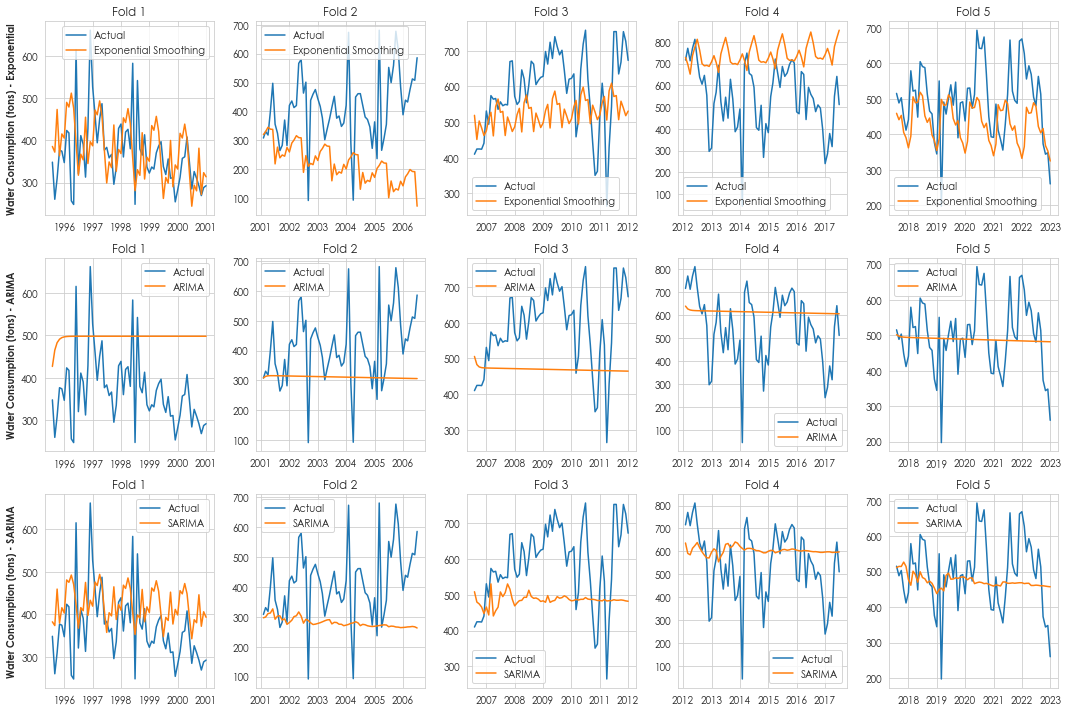

In [178]:
# Perform Cross-Validation of the plots on 5 folds for all the models

# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Set the style and font for the plots
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Create a 3x5 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=n_cv_folds, figsize=(15, 10))

# Define the model names
model_names = ['Exponential Smoothing', 'ARIMA', 'SARIMA']

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(tscv.split(energy_df_final), start=1):
    cv_train_water = energy_df_final.iloc[train_index]
    cv_test_water = energy_df_final.iloc[test_index]

    # Exponential Smoothing Holt Winters
    hwes_model = ExponentialSmoothing(cv_train_water['Water Consumption (tons)'], trend='add', seasonal='add', seasonal_periods=12)
    hwes_fit = hwes_model.fit()
    hwes_predict = hwes_fit.predict(start=cv_test_water.index[0], end=cv_test_water.index[-1])
    
    # ARIMA Model
    arima_model = SARIMAX(cv_train_water['Water Consumption (tons)'], order=(2,0,1))
    arima_fit = arima_model.fit(disp=False)
    arima_predict = arima_fit.predict(start=cv_test_water.index[0], end=cv_test_water.index[-1])
    
    # SARIMA Model
    sarima_model = SARIMAX(cv_train_water['Water Consumption (tons)'], order=(2,0,1), seasonal_order=(2,0,1,12))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_predict= sarima_fit.predict(start=cv_test_water.index[0], end=cv_test_water.index[-1])
    
    # Plot actual vs. predicted values for each model
    for model_idx, (model_name, predict_values) in enumerate(zip(model_names, [hwes_predict, arima_predict, sarima_predict])):
        axes[model_idx, fold-1].plot(cv_test_water.index, cv_test_water['Water Consumption (tons)'], label='Actual')
        axes[model_idx, fold-1].plot(cv_test_water.index, predict_values, label=model_name)
        axes[model_idx, fold-1].set_title(f"Fold {fold}")
        axes[model_idx, fold-1].legend()

# Set common y-axis labels for each row
axes[0, 0].set_ylabel('Water Consumption (tons) - Exponential', fontweight='bold')
axes[1, 0].set_ylabel('Water Consumption (tons) - ARIMA', fontweight='bold')
axes[2, 0].set_ylabel('Water Consumption (tons) - SARIMA', fontweight='bold')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### PLOTTING LAG PLOTS TO DETERMINE AUTOCORRELATION

To identify any recurring patterns or dependencies within the data for water consumption, lag plots are plotted using lag_plot to visualise the relationship between a data point and its lagged counterpart at a specified time interval.

Based on the lag plots, at y(t+1) to y(t+4), there seems to be a positive correlation in the plots, indicating that past values of the time series does have an influence on its future values. Furthermore, repeated correlations at regular intervals indicate that data contains seasonality, showing seasonal correlations, further supporting the need to use the SARIMA Model for evaluation.

The lag plots are seen to gradually move away from the diagonal line in this case, indicating seasonal behaviour in the data for water consumption.

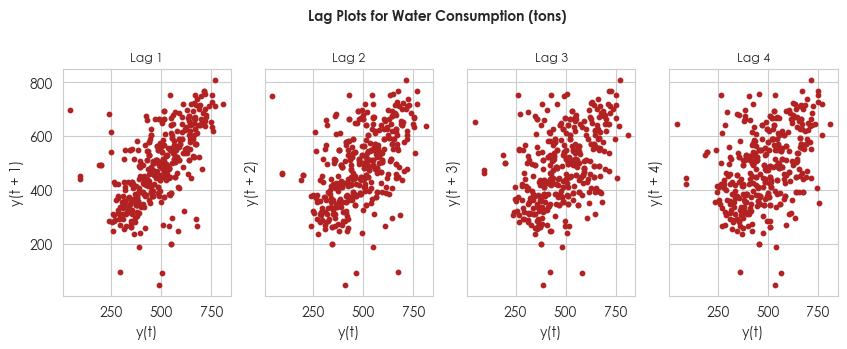

In [154]:
# Plot the lag plots for water consumption

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Create a figure and a grid of subplots for lag plots
fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True, dpi=100)

# Loop through lag values and create lag plots
for i, ax in enumerate(axes.flatten()[:4]):
    
    # Generate a lag plot for 'Water Consumption (tons)' time series data
    lag_plot(energy_df_final['Water Consumption (tons)'], lag=i + 1, ax=ax, c='firebrick', s=10)
    
    # Set the title for the current lag plot
    ax.set_title('Lag ' + str(i + 1), fontsize=9)

# Set a super title for the entire figure
fig.suptitle('Lag Plots for Water Consumption (tons)', y=1.08, fontweight='bold', fontsize=10)

# Display the lag plots
plt.show()

### EVALUATING THE SARIMA MODEL FOR WATER CONSUMPTION (TONS)

### INITIALIZING AND FINETUNING THE SARIMA MODEL FOR WATER CONSUMPTION (TONS) 

- To improve the forecasting accuracy of the SARIMA model for water consumption, hyperparameters need to be optimized.
- Store the parameters into ranges and loop through the parameters.
- Fit the best parameters to the model for training and testing.

Parameters Used:
- `p_range`: The order of the autoregressive (AR) component, which captures the dependence on past observations.
- `d_range`: The order of differencing, which helps achieve stationarity by removing trends.
- `q_range`: The order of the moving average (MA) component, which accounts for the influence of past error terms.
- `seasonal`: The order of the seasonal autoregressive (SAR) component, capturing seasonality patterns.
- `p1_range`: The order of the seasonal autoregressive (SAR) component for seasonal differencing.
- `d1_range`: The order of seasonal differencing to achieve stationarity.
- `q1_range`: The order of the seasonal moving average (SMA) component, accounting for seasonal errors.

Summary Table Ranking the Parameters Contains:
- `p`, `d`, `q`: The orders of AR, differencing, and MA components.
- `p1`, `d1`, `q1`, `r`: The orders of seasonal AR, seasonal differencing, seasonal MA components, and the seasonal period.
- `MAPE`, `MSE`, `RMSE`: Forecast accuracy metrics.
- `AIC`, `BIC`: Information criteria indicating model goodness-of-fit.

<b>Sort the values in the table according to AIC (ascending) as the main goal of the analysis is to identify good predictive models, which AIC helps achieve.</b>

In [179]:
# Tuning the hyperparameters for Water Consumption (tons) using SARIMA Model

# Specify the ranges for the parameter values
p_range = range(1, 4) # Order of the autoregressive (AR) component
d_range = [0] # Order of differencing - differencing is not needed for water consumption
q_range = range(1, 3) # Order of moving average (MA) component
seasonal = [12] # Order of seasonal autoregressive (SAR) component
p1_range = range(1, 4) # Order of seasonal autoregressive (SAR) component for seasonal differencing
d1_range = range(0, 2) # Order of seasonal differencing
q1_range = range(1, 6) # Order of seasonal moving average (SMA) component

# Store the results into an array
water_results = []

# Loop through the parameter combinations to find the best parameters
for p in p_range:
    for d in d_range:
        for q in q_range:
            for r in seasonal:
                for p1 in p1_range:
                    for d1 in d1_range:
                        for q1 in q1_range:
                            # Create and fit the SARIMA(p,d,q) model
                            water_model = SARIMAX(train_data['Water Consumption (tons)'], order = (p,d,q), seasonal_order = (p1,d1,q1,r), enforce_stationarity=False)
                            # Fit SARIMA model to the model
                            sarima_tuned = water_model.fit()
                            
                            # Make a SARIMA forecast 
                            sarima_forecast = sarima_tuned.get_forecast(steps=60).predicted_mean
                            
                            # Obtain evaluation metrics using validation data
                            mape = mean_absolute_percentage_error(validation_data['Water Consumption (tons)'], sarima_forecast)*100
                            mse = mean_squared_error(validation_data['Water Consumption (tons)'], sarima_forecast)
                            rmse = np.sqrt(mse)

                            water_results.append((p, d, q, p1, d1, q1, r, mape, mse, rmse, sarima_tuned.aic, sarima_tuned.bic))
                            
# Construct a dataframe to store the values from the tuning
order_water = pd.DataFrame(water_results, columns=['p','d','q','p1','d1','q1','r','MAPE','MSE', 'RMSE', 'AIC', 'BIC'])

# Print order_water in order of increasing AIC
aic_order = order_water.sort_values('AIC')

# Display the dataframe of results
print('Summary Table for Water Consumption (tons) Seasonal Order (SARIMA) :')
aic_order

Summary Table for Water Consumption (tons) Seasonal Order (SARIMA) :


,p,d,q,p1,d1,q1,r,MAPE,MSE,RMSE,AIC,BIC
39,1,0,2,1,1,5,12,40.032578,18811.613917,137.155437,2470.401699,2503.533759
59,1,0,2,3,1,5,12,40.534140,19709.795341,140.391579,2476.331441,2516.089913
19,1,0,1,2,1,5,12,41.193549,20479.174907,143.105468,2485.634777,2518.815977
9,1,0,1,1,1,5,12,40.406655,19748.354721,140.528839,2487.964638,2517.827718
79,2,0,1,2,1,5,12,38.168777,19688.007042,140.313959,2487.972691,2524.472011
...,...,...,...,...,...,...,...,...,...,...,...,...
30,1,0,2,1,0,1,12,37.914322,21713.482127,147.354953,3171.352689,3192.785613
120,3,0,1,1,0,1,12,47.085772,24097.524471,155.233774,3172.234539,3197.239617
150,3,0,2,1,0,1,12,46.842606,23803.874380,154.285043,3173.012702,3201.589934
60,2,0,1,1,0,1,12,48.083579,25259.063844,158.931003,3181.513615,3202.969309


### RETRIEVE TOP 5 RESULTS FOR MODEL EVALUATION SORTED BY RMSE, MAPE AND AIC

- Sort the tuned results in the dataframe by RMSE, MAPE and AIC.
- BIC is not used to sort the data as it is more important to identify good predictive models in this analysis.
- Based on the results obtained, determine the best order and seasonal order configuration for predicting water consumption.

In [182]:
# Obtaining the top 5 results for model evaluation sorted by RMSE, MAPE and AIC

# Sort the table by order of RMSE, MAPE, and AIC
orderwater_rmse = order_water.sort_values('RMSE').head()
orderwater_mape = order_water.sort_values('MAPE').head()
orderwater_aic = order_water.sort_values('AIC').head()

# Add labels to indicate the segments
orderwater_rmse['Segment'] = 'Best RMSE'
orderwater_mape['Segment'] = 'Best MAPE'
orderwater_aic['Segment'] = 'Best AIC'

# Create separate dataframes for each segment
summarytable_rmse = orderwater_rmse[['Segment', 'p', 'd', 'q', 'p1', 'd1', 'q1', 'r', 'MAPE', 'MSE', 'RMSE', 'AIC']]
summarytable_mape = orderwater_mape[['Segment', 'p', 'd', 'q', 'p1', 'd1', 'q1', 'r', 'MAPE', 'MSE', 'RMSE', 'AIC']]
summarytable_aic = orderwater_aic[['Segment', 'p', 'd', 'q', 'p1', 'd1', 'q1', 'r', 'MAPE', 'MSE', 'RMSE', 'AIC']]

# Sort each summarytable dataframe by the corresponding metric (RMSE, MAPE, AIC)
summarytable_rmse['Segment'] = pd.Categorical(summarytable_rmse['Segment'], ordered=True)
summarytable_rmse = summarytable_rmse.sort_values(by=['RMSE'], ascending=True)

summarytable_mape['Segment'] = pd.Categorical(summarytable_mape['Segment'], ordered=True)
summarytable_mape = summarytable_mape.sort_values(by=['MAPE'], ascending=True)

summarytable_aic['Segment'] = pd.Categorical(summarytable_aic['Segment'], ordered=True)
summarytable_aic = summarytable_aic.sort_values(by=['AIC'], ascending=True)

# Display the summarytables
print("Summary Table for Water Consumption (tons) Seasonal Order (SARIMA) - Best MAPE:")
print(summarytable_mape.round(3))

print("\nSummary Table for Water Consumption (tons) Seasonal Order (SARIMA) - Best RMSE:")
print(summarytable_rmse.round(3))

print("\nSummary Table for Water Consumption (tons) Seasonal Order (SARIMA) - Best AIC:")
print(summarytable_aic.round(3))

Summary Table for Water Consumption (tons) Seasonal Order (SARIMA) - Best MAPE:
       Segment  p  d  q  p1  d1  q1   r    MAPE        MSE     RMSE       AIC
56   Best MAPE  1  0  2   3   1   2  12  37.641  19192.080  138.535  2784.702
38   Best MAPE  1  0  2   1   1   4  12  37.842  19762.804  140.580  2609.948
30   Best MAPE  1  0  2   1   0   1  12  37.914  21713.482  147.355  3171.353
175  Best MAPE  3  0  2   3   1   1  12  38.001  18125.639  134.631  2763.390
98   Best MAPE  2  0  2   1   1   4  12  38.016  18956.932  137.684  2618.053

Summary Table for Water Consumption (tons) Seasonal Order (SARIMA) - Best RMSE:
       Segment  p  d  q  p1  d1  q1   r    MAPE        MSE     RMSE       AIC
175  Best RMSE  3  0  2   3   1   1  12  38.001  18125.639  134.631  2763.390
68   Best RMSE  2  0  1   1   1   4  12  39.594  18227.471  135.009  2630.434
41   Best RMSE  1  0  2   2   0   2  12  40.615  18240.205  135.056  3020.279
133  Best RMSE  3  0  1   2   0   4  12  40.257  18323.261 

### RE-FITTING THE SARIMA MODEL WITH HYPERPARAMETERS

- Initialize and fit the SARIMA Model using .fit() and specify the order and seasonal order.
- Obtain evaluation metrics on the testing set and generate the diagnostics plots for the model.

                                            SARIMAX Results                                             
Dep. Variable:                         Water Consumption (tons)   No. Observations:                  278
Model:             SARIMAX(1, 0, 2)x(1, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood               -1225.201
Date:                                          Fri, 11 Aug 2023   AIC                           2470.402
Time:                                                  22:16:27   BIC                           2503.534
Sample:                                              01-01-1990   HQIC                          2483.806
                                                   - 02-01-2013                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

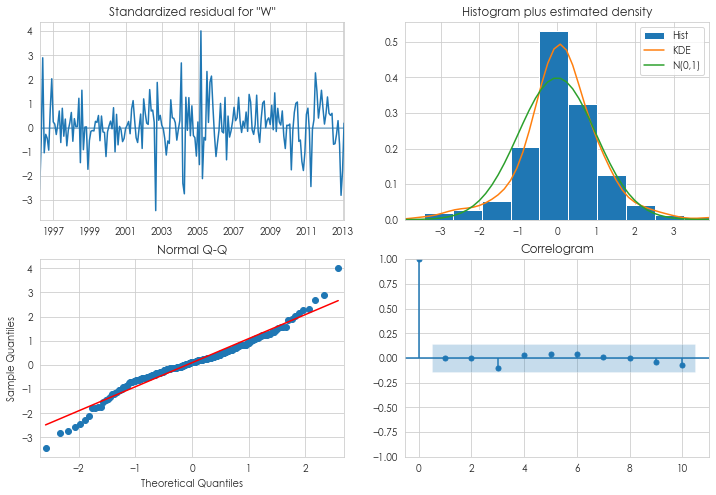

In [228]:
# Refitting the SARIMA Model with tuned values

# Define the SARIMA Model
model_water = SARIMAX(train_data['Water Consumption (tons)'], order=(1,0,2), enforce_stationarity = False, seasonal_order=(1,1,5,12))

# Fit the SARIMA model
sarima_tuned = model_water.fit()
# Print the summary of the results
print(sarima_tuned.summary())

# Make an SARIMA forecast 
sarima_forecast = sarima_tuned.get_forecast(steps=59).predicted_mean

# Obtain evaluation metrics from SARIMA
mape = mean_absolute_percentage_error(test_data['Water Consumption (tons)'], sarima_forecast)*100
mse = mean_squared_error(test_data['Water Consumption (tons)'], sarima_forecast)
rmse = np.sqrt(mse)

# Printing the evaluation metrics 
print("\n=================================================================\n\tEvaluation Metrics for Water Consumption (tons)\n=================================================================")
print("MAPE on Test Data:", mape)
print("MSE on Test Data:", mse)
print("RMSE on Test Data:", rmse, "\n")

# Create the 4 diagostics plots
sarima_tuned.plot_diagnostics(figsize=(12,8))
plt.show()

### VISUALIZING THE FINAL FORECAST VALUES OF WATER CONSUMPTION

- Generate predictions using the tuned SARIMA model for the specified time range from 1990 to 2023.
- Plot the training and testing data and predict on the training data using .get_prediction.
- Generate forecast (future) values for the next 59 periods and set the frequency of the data to 'M' (monthly).

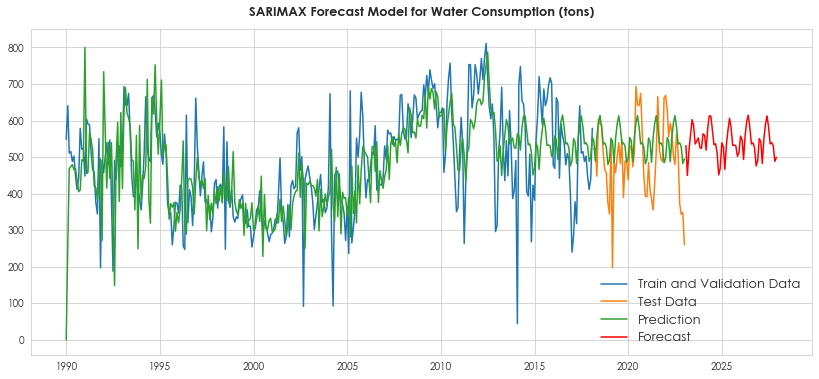

In [229]:
# Plotting the tuned SARIMA graph for Water Consumption

# Generate predictions using the tuned SARIMA model for the specified time range
water_pred = sarima_tuned.get_prediction(start='1990-01-01', end='2023-01-01').predicted_mean

# Create a new figure and axis for the plot, specifying the size
fig, ax = plt.subplots(figsize=(14, 6))

# Plot the actual training data and testing data
ax.plot(pd.concat([train_data['Water Consumption (tons)'], validation_data['Water Consumption (tons)']]), label='Train and Validation Data')
ax.plot(test_data['Water Consumption (tons)'], label='Test Data')
ax.plot(water_pred, label='Prediction')

# Generate forecast values
sarima_forecast = sarima_tuned.get_forecast(steps=59).predicted_mean

# Plot the forecasted future values
forecast_values = pd.date_range(start='2023-01-02', periods=59, freq='M')  # Adjust the date range and frequency
ax.plot(forecast_values, sarima_forecast, label='Forecast', color='red')

# Add legend to the plot
plt.legend(frameon=False, fontsize=13)
# Setting the title to the plot
plt.title('SARIMAX Forecast Model for Water Consumption (tons)', fontsize=13, fontweight='bold', y=1.02)

# Display the plot
plt.show()

### <font color='green'> CONSUMPTION TYPE 3 : ELECTRICITY CONSUMPTION (MWH)</font>

### OBTAIN THE AUTOCORRELATION AND PARTIAL AUTOCORRELATION PLOTS

- From the ACF plot, there are no significant spikes in the lags, hence the ACF plot for electricity consumption data is inconclusive, indicating a weak moving average component.


- From the PACF plot, it has one significant spike at lag1, indicating that an AR(1) process is suitable for electricity consumption data.

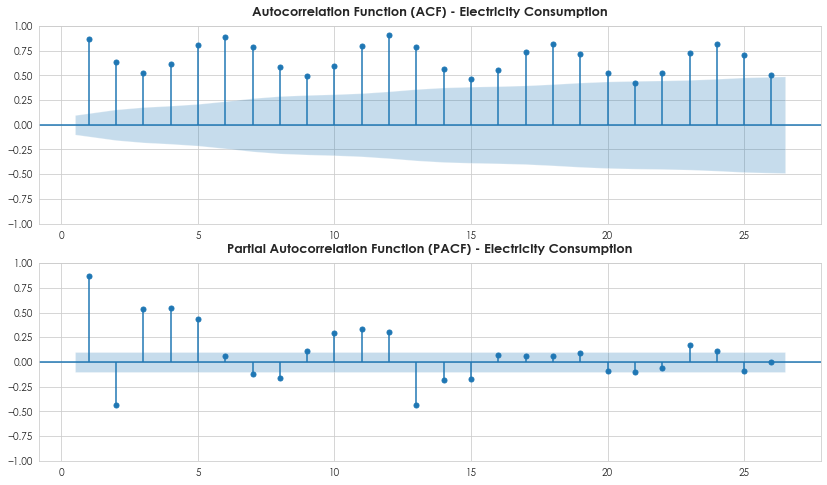

In [36]:
# Plotting the ACF and PACF plots for Electricity Consumption

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Create the figure axes
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,8))

# Plot the ACF for Electricity Consumption
plot_acf(energy_df_final['Electricity Consumption (MWh)'], zero=False, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) - Electricity Consumption', fontsize=13, fontweight='bold', y=1.02)

# Plot the PACF for Electricity Consumption
plot_pacf(energy_df_final['Electricity Consumption (MWh)'], zero=False, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) - Electricity Consumption', fontsize=13, fontweight='bold', y=1.02)

plt.show()

### INVESTIGATE SEASONALITY USING THE SEASONAL DECOMPOSITION PLOT

- To determine seasonality, use the 'seasonal_decompose' function to plot the seasonal decomposition plot.
- Specify model as 'additive' as it is seen that seasonal fluctuations do not vary significantly as electricity consumption levels change, and the patterns in seasonality is the same throughout.


- Under 'seasonal' in the plot, we can see that there is seasonality in electricity consumption due to the regular, consistent fluctuations occuring between 1990 to 2023.
- Under 'resid' in the plot, the residuals appear to follow a random pattern with a number of outliers further away from zero, hence it is necessary to perform hyperparameter tuning to improve the performance of the model.

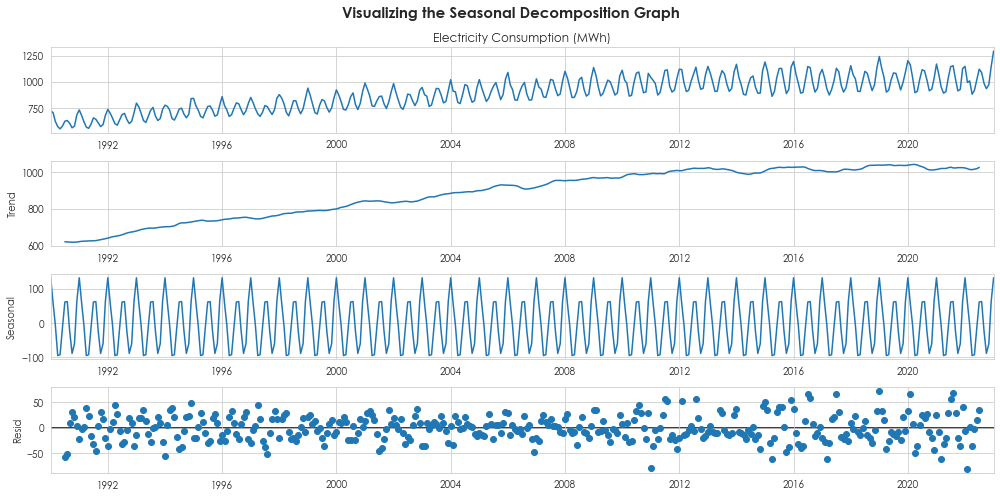

In [73]:
# Plot the seasonal decomposition graph to investigate seasonality

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Perform seasonal decomposition
electricity_decomp = seasonal_decompose(energy_df_final['Electricity Consumption (MWh)'], model='additive')

# Plot the decomposition graph
fig = electricity_decomp.plot()
fig.set_size_inches((14,7))

# Create a title with a larger font size
title = fig.suptitle('Visualizing the Seasonal Decomposition Graph', x=0.51, fontweight='bold')
title.set_fontsize(15)

# Display the figure
plt.tight_layout()
plt.show()

### DETERMINE SEASONAL PERIOD USING SEASONAL AUTOCORRELATION PLOT

- Using the seasonal decomposition graph, plot a seasonal ACF plot to determine the seasonal period for electricity consumption.
- Significant spikes extending beyond the significance bands indicate the presence of seasonal patterns.
- From the plot, it is clear that the spike occurs at the period 12, indicating that the seasonal period for water consumption is likely to be 12.

Seasonal Period for Electricity Consumption : 12


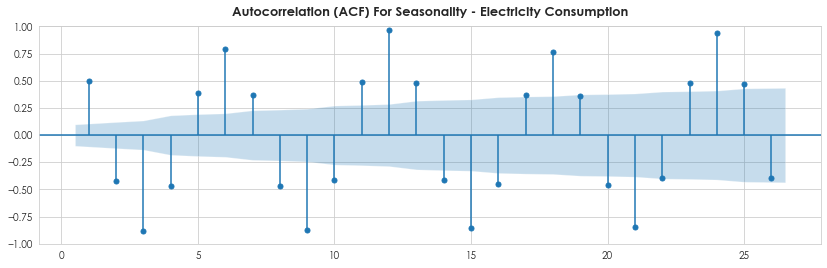

In [108]:
# Plotting the autocorrelation plot to determine seasonal period

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Create the figure axes
fig, (ax1) = plt.subplots(1,1, figsize=(14,4))

plot_acf(electricity_decomp.seasonal, zero=False, ax=ax1)
ax1.set_title('Autocorrelation (ACF) For Seasonality - Electricity Consumption', fontsize=13, y=1.02, fontweight='bold')
print("Seasonal Period for Electricity Consumption :", len(electricity_decomp.seasonal.drop_duplicates()))
plt.show()

### CROSS-VALIDATION OF MODELS FOR ELECTRICITY CONSUMPTION (MWH)

- Compare the performance of different models using time series cross-validation where cv folds = 5.
- Obtain the mean average percentage error, mean squared error and root mean squared error for each model and retrieve the results. 
- The lower the metric values, the better the model for time series prediction.
- From the cross-validation, it is clear that the <b>Holt-Winters Exponential Smoothing Model</b> provides the lowest error rate of <b>0.0363 for MAPE</b>.

In [173]:
# Perform Cross-Validation on Models for Electricity Consumption (MWh)

# Initialise and store the error metrics in lists
mape_scores_exp = []
mse_scores_exp = []
rmse_scores_exp = []

mape_scores_arima = []
mse_scores_arima = []
rmse_scores_arima = []

mape_scores_sarima = []
mse_scores_sarima = []
rmse_scores_sarima = []

# Perform time series cross validation for electricity consumption in MWh
tscv = TimeSeriesSplit(n_splits=5)

# Indexing for training and testing set in the data
for train_idx, test_idx in tscv.split(energy_df_final):
    cv_train_electricity = energy_df_final.iloc[train_idx]
    cv_test_electricity = energy_df_final.iloc[test_idx]
    
    # Exponential Smoothing Holt Winters
    hwes_model = ExponentialSmoothing(cv_train_electricity['Electricity Consumption (MWh)'], trend='add', seasonal='add', seasonal_periods=12)
    hwes_fit = hwes_model.fit()
    hwes_predict = hwes_fit.predict(start=cv_test_electricity.index[0], end=cv_test_electricity.index[-1])
    
    # ARIMA Model
    arima_model = SARIMAX(cv_train_electricity['Electricity Consumption (MWh)'], order=(1,1,1))
    arima_fit = arima_model.fit(disp=False)
    arima_predict = arima_fit.predict(start=cv_test_electricity.index[0], end=cv_test_electricity.index[-1])
    
    # SARIMA Model
    sarima_model = SARIMAX(cv_train_electricity['Electricity Consumption (MWh)'], order=(1,1,1), seasonal_order=(2,1,5,12))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_predict = sarima_fit.predict(start=cv_test_electricity.index[0], end=cv_test_electricity.index[-1])
    
    # Calculate error metrics for Exponential Smoothing
    mape_scores_exp.append(mean_absolute_error(cv_test_electricity['Electricity Consumption (MWh)'], hwes_predict) / cv_test_electricity['Electricity Consumption (MWh)'])
    mse_scores_exp.append(mean_squared_error(cv_test_electricity['Electricity Consumption (MWh)'], hwes_predict))
    rmse_scores_exp.append(np.sqrt(mean_squared_error(cv_test_electricity['Electricity Consumption (MWh)'], hwes_predict)))
    
    # Calculate error metrics for ARIMA
    mape_scores_arima.append(mean_absolute_error(cv_test_electricity['Electricity Consumption (MWh)'], arima_predict) / cv_test_electricity['Electricity Consumption (MWh)'])
    mse_scores_arima.append(mean_squared_error(cv_test_electricity['Electricity Consumption (MWh)'], arima_predict))
    rmse_scores_arima.append(np.sqrt(mean_squared_error(cv_test_electricity['Electricity Consumption (MWh)'], arima_predict)))
    
    # Calculate error metrics for SARIMA
    mape_scores_sarima.append(mean_absolute_error(cv_test_electricity['Electricity Consumption (MWh)'], sarima_predict) / cv_test_electricity['Electricity Consumption (MWh)'])
    mse_scores_sarima.append(mean_squared_error(cv_test_electricity['Electricity Consumption (MWh)'], sarima_predict))
    rmse_scores_sarima.append(np.sqrt(mean_squared_error(cv_test_electricity['Electricity Consumption (MWh)'], sarima_predict)))
    
# Calculate average error rates for each metric for Exponential Smoothing
average_mape_exp = np.mean(mape_scores_exp)
average_mse_exp = np.mean(mse_scores_exp)
average_rmse_exp = np.mean(rmse_scores_exp)

# Calculate average error rates for each metric for ARIMA
average_mape_arima = np.mean(mape_scores_arima)
average_mse_arima = np.mean(mse_scores_arima)
average_rmse_arima = np.mean(rmse_scores_arima)

# Calculate average error rates for each metric for SARIMA
average_mape_sarima = np.mean(mape_scores_sarima)
average_mse_sarima = np.mean(mse_scores_sarima)
average_rmse_sarima = np.mean(rmse_scores_sarima)
    
# Display the results
print("Cross-Validation Evaluation Metrics for Electricity Consumption (MWh):\n")

# Print the results for Exponential Smoothing
print("Exponential Smoothing for Electricity Consumption (MWh):")
print(f"Average MAPE: {average_mape_exp:.4f}")
print(f"Average MSE: {average_mse_exp:.4f}")
print(f"Average RMSE: {average_rmse_exp:.4f}\n")

# Print the results for ARIMA
print("ARIMA for Electricity Consumption (MWh):")
print(f"Average MAPE: {average_mape_arima:.4f}")
print(f"Average MSE: {average_mse_arima:.4f}")
print(f"Average RMSE: {average_rmse_arima:.4f}\n")

# Print the results for SARIMA
print("SARIMA for Electricity Consumption (MWh):")
print(f"Average MAPE: {average_mape_sarima:.4f}")
print(f"Average MSE: {average_mse_sarima:.4f}")
print(f"Average RMSE: {average_rmse_sarima:.4f}")

Cross-Validation Evaluation Metrics for Electricity Consumption (MWh):

Exponential Smoothing for Electricity Consumption (MWh):
Average MAPE: 0.0363
Average MSE: 1737.6828
Average RMSE: 40.7652

ARIMA for Electricity Consumption (MWh):
Average MAPE: 0.1234
Average MSE: 19977.5369
Average RMSE: 133.4443

SARIMA for Electricity Consumption (MWh):
Average MAPE: 0.0378
Average MSE: 1940.4858
Average RMSE: 42.2645


### CROSS-VALIDATION OF THE PREDICTION PLOTS FOR THE VARIOUS MODELS

- Create a subplot grid to display the actual vs. predicted water consumption values for each model in each of the 5 folds.

- Fit and predict the training data to the respective models using .fit() and .predict(), and plot the relevant plots for each model.

- From the plots, it is clear that the predicted values (in orange) for the Holt-Winters Exponential Smoothing Model is best fitted to follow the trend of the original data, hence supporting the decision to choose Holt-Winters Exponential Smoothing Model as the final model for time series forecasting of electricity consumption.

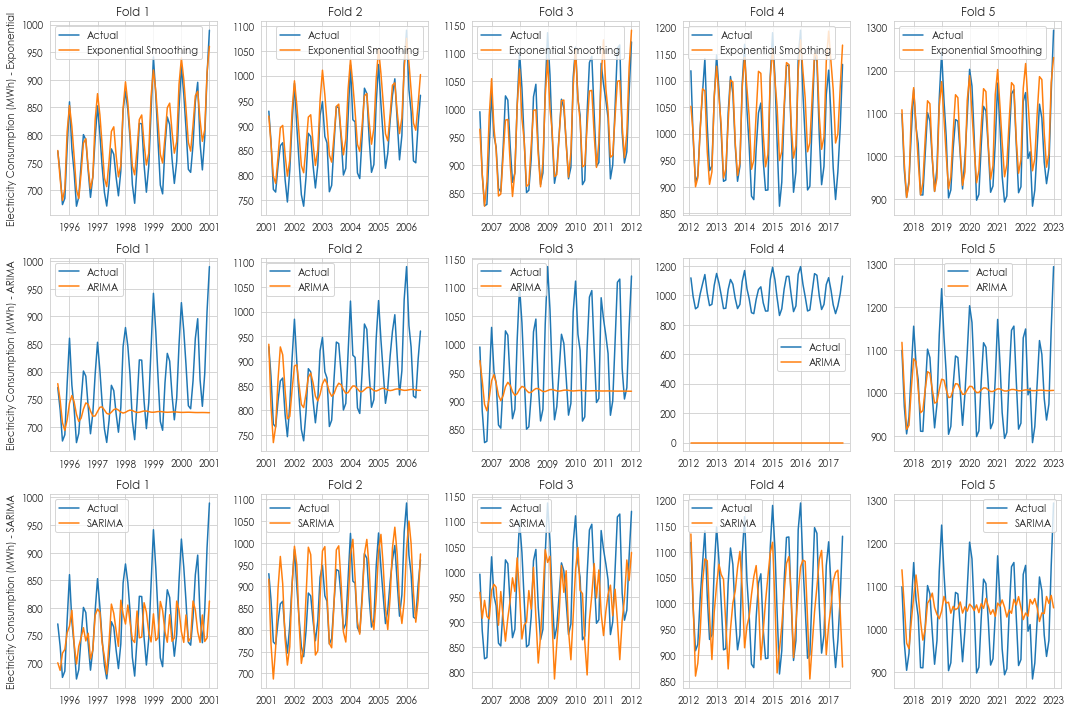

In [68]:
# Perform Cross-Validation of the plots on 5 folds for all the models

# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Set the style and font for the plots
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Create a 3x5 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=n_cv_folds, figsize=(15, 10))

# Define the model names
model_names = ['Exponential Smoothing', 'ARIMA', 'SARIMA']

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(tscv.split(energy_df_final), start=1):
    cv_train_electricity = energy_df_final.iloc[train_index]
    cv_test_electricity = energy_df_final.iloc[test_index]

    # Exponential Smoothing Holt Winters
    hwes_model = ExponentialSmoothing(cv_train_electricity['Electricity Consumption (MWh)'], trend='add', seasonal='add', seasonal_periods=12)
    hwes_fit = hwes_model.fit()
    hwes_predict = hwes_fit.predict(start=cv_test_electricity.index[0], end=cv_test_electricity.index[-1])
    
    # ARIMA Model
    arima_model = SARIMAX(cv_train_electricity['Electricity Consumption (MWh)'], order=(3,0,1))
    arima_fit = arima_model.fit(disp=False)
    arima_predict = arima_fit.predict(start=cv_test_electricity.index[0], end=cv_test_electricity.index[-1])
    
    # SARIMA Model
    sarima_model = SARIMAX(cv_train_electricity['Electricity Consumption (MWh)'], order=(3,0,1), seasonal_order=(2,1,5,7))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_predict= sarima_fit.predict(start=cv_test_electricity.index[0], end=cv_test_electricity.index[-1])
    
    # Plot actual vs. predicted values for each model
    for model_idx, (model_name, predict_values) in enumerate(zip(model_names, [hwes_predict, arima_predict, sarima_predict])):
        axes[model_idx, fold-1].plot(cv_test_electricity.index, cv_test_electricity['Electricity Consumption (MWh)'], label='Actual')
        axes[model_idx, fold-1].plot(cv_test_electricity.index, predict_values, label=model_name)
        axes[model_idx, fold-1].set_title(f"Fold {fold}")
        axes[model_idx, fold-1].legend()

# Set common y-axis labels for each row
axes[0, 0].set_ylabel('Electricity Consumption (MWh) - Exponential', fontweight='bold')
axes[1, 0].set_ylabel('Electricity Consumption (MWh) - ARIMA', fontweight='bold')
axes[2, 0].set_ylabel('Electricity Consumption (MWh) - SARIMA', fontweight='bold')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### PLOTTING LAG PLOTS TO DETERMINE AUTOCORRELATION

To identify any recurring patterns or dependencies within the data for water consumption, lag plots are plotted using lag_plot to visualise the relationship between a data point and its lagged counterpart at a specified time interval.

Based on the lag plots, at y(t+1) to y(t+4), there seems to be a positive correlation in the plots, indicating that past values of the time series does have an influence on its future values. Furthermore, repeated correlations at regular intervals indicate that data contains seasonality, showing seasonal correlations, further supporting the need to use the SARIMA Model for evaluation.

The lag plots are seen to gradually move away from the diagonal line in this case, also indicating seasonal behaviour in the data for electricity consumption.

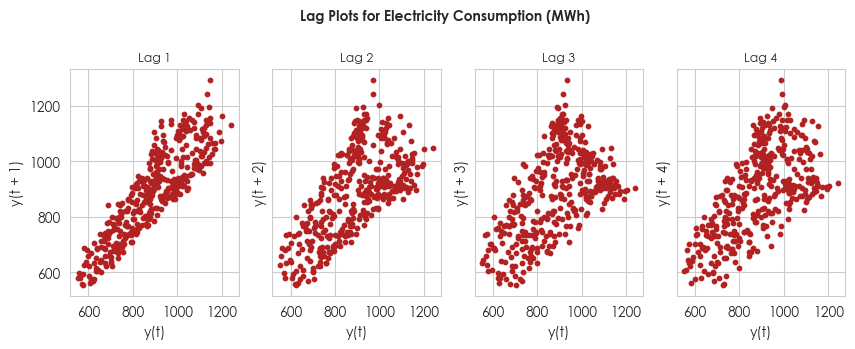

In [40]:
# Plot the lag plots for electricity consumption

# Set the style and font for the plot
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Century Gothic'

# Create a figure and a grid of subplots for lag plots
fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True, dpi=100)

# Loop through lag values and create lag plots
for i, ax in enumerate(axes.flatten()[:4]):
    
    # Generate a lag plot for 'Electricity Consumption (MWh)' time series data
    lag_plot(energy_df_final['Electricity Consumption (MWh)'], lag=i + 1, ax=ax, c='firebrick', s=10)
    
    # Set the title for the current lag plot
    ax.set_title('Lag ' + str(i + 1), fontsize=9)

# Set a super title for the entire figure
fig.suptitle('Lag Plots for Electricity Consumption (MWh)', y=1.08, fontweight='bold', fontsize=10)

# Display the lag plots
plt.show()

### EVALUATING THE EXPONENTIAL SMOOTHING MODEL FOR ELECTRICITY CONSUMPTION (MWH)

### INITIALIZING AND FINETUNING THE HWES MODEL FOR ELECTRICITY CONSUMPTION (MWH)

- To improve the forecasting accuracy of the Holt Winter's Exponential Smoothing model for electricity consumption, hyperparameters need to be optimized.
- Store the parameters into ranges and loop through the parameters.
- Fit the best parameters to the model for training and testing.

Parameters Used:
- `trend_range`: Specifies trend type in the model - 'Add' for additive trend (constant changes) and 'Mul' for multiplicative trend (growing/shrinking changes).

- `damped_trend_range`: Controls whether trend growth is damped (True) or not (False) in the model.

- `seasonal_range`: Chooses seasonal type - 'Add' for additive seasonal patterns and 'Mul' for multiplicative seasonal patterns.

- `seasonal`: Specifies the number of periods in a complete season, helping the model capture repeating patterns in the data.

Summary Table Ranking the Parameters Contains:
- `trend_range`, `damped_trend_range`, `seasonal_range`, `seasonal`: Influences the behavior and characteristics of the Exponential Smoothing model
- `MAPE`, `MSE`, `RMSE`: Forecast accuracy metrics.

<b>Despite having non-stationary data for electricity consumption (MWh), differencing was not applied as Holt-Winters' Exponential Smoothing is designed to capture and forecast trends and seasonality in time series data, even if the data is not strictly stationary.</b>

In [218]:
# Tuning the hyperparameters for Electricity Consumption (MWH) using Holt-Winters Exponential Smoothing

# Specify the ranges for the parameter values
trend_range = ['Add', 'Mul'] # Specifies trend type in the model - 'Add' for additive trend (constant changes) and 'Mul' for multiplicative trend (growing/shrinking changes)
damped_trend_range = [True, False] # Controls whether trend growth is damped (True) or not (False) in the model
seasonal_range = ['Add', 'Mul'] # Chooses seasonal type - 'Add' for additive seasonal patterns and 'Mul' for multiplicative seasonal patterns.
seasonal = [12] # Specifies the number of periods in a complete season

# Store the results into an array
electricity_results = []

# Loop through the parameter combinations to find the best parameters
for trend_type in trend_range:
    for damped_trend in damped_trend_range:
        for seasonal_type in seasonal_range:
            for r in seasonal:
                # Create the Holt-Winters model with the specified hyperparameters
                electricity_model = ExponentialSmoothing(train_data['Electricity Consumption (MWh)'], trend=trend_type, seasonal=seasonal_type, seasonal_periods=r, damped_trend=damped_trend)
                # Fit Holt-Winters model to the model
                expo_tuned = electricity_model.fit()
                        
                # Make a forecast
                expo_forecast = expo_tuned.forecast(steps=60)
                            
                # Obtain evaluation metrics using validation data
                mape = mean_absolute_percentage_error(validation_data['Electricity Consumption (MWh)'], expo_forecast)*100
                mse = mean_squared_error(validation_data['Electricity Consumption (MWh)'], expo_forecast)
                rmse = np.sqrt(mse)

                electricity_results.append((trend_type, damped_trend, seasonal_type, r, mape, mse, rmse))
                            
# Construct a dataframe to store the values from the tuning
order_electricity = pd.DataFrame(electricity_results, columns=['Trend Type','Damped Trend', 'Seasonal Type', 'Seasonal','MAPE','MSE','RMSE'])

# Print order_electricity in order of increasing MAPE
mape_order = order_electricity.sort_values('MAPE')

# Display the dataframe of results
print('Summary Table for Electricity Consumption (MWh) Holt-Winters Exponential Model (HWES) :')
mape_order

Summary Table for Electricity Consumption (MWh) Holt-Winters Exponential Model (HWES) :


,Trend Type,Damped Trend,Seasonal Type,Seasonal,MAPE,MSE,RMSE
1,Add,True,Mul,12,2.683466,1061.968353,32.587856
5,Mul,True,Mul,12,3.386934,1652.229856,40.647630
4,Mul,True,Add,12,3.719418,1908.381688,43.685028
0,Add,True,Add,12,3.722864,1863.236727,43.165226
3,Add,False,Mul,12,4.125485,2502.403937,50.024034
7,Mul,False,Mul,12,5.149045,3912.874152,62.552971
2,Add,False,Add,12,5.786758,4450.253477,66.710220
6,Mul,False,Add,12,6.529776,5677.796182,75.351152


### VISUALIZING THE FINAL FORECAST VALUES OF ELECTRICITY CONSUMPTION

- Generate predictions using the tuned Holt-Winters Exponential Smoothing model for the specified time range from 1990 to 2023.
- Plot the training, validation and testing data and set .forecast to steps = 60.

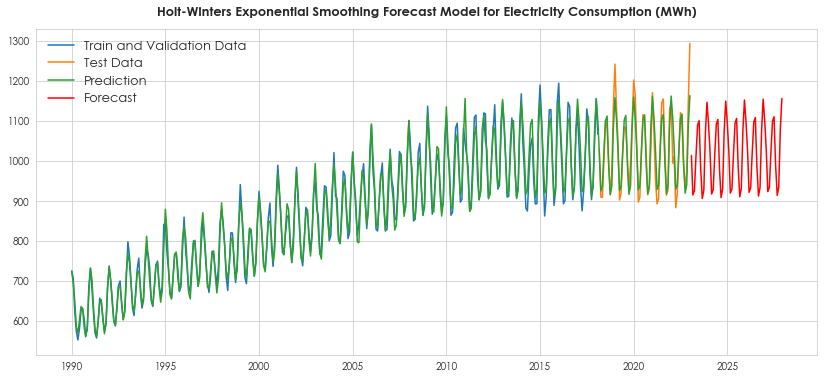

In [232]:
# Plotting the tuned HWES graph for Electricity Consumption

# Fit the top results to the final tuned model
electricity_model_tuned = ExponentialSmoothing(train_data['Electricity Consumption (MWh)'], trend='add', seasonal='mul', seasonal_periods=12, damped_trend=True)

# Generate predictions using the tuned Exponential Smoothing model for the specified time range
expo_tuned = electricity_model_tuned.fit()
electricity_pred = expo_tuned.predict(start='1990-01-01', end='2023-01-01')

# Create a new figure and axis for the plot, specifying the size
fig, ax = plt.subplots(figsize=(14, 6))

# Plot the actual training data and testing data
ax.plot(pd.concat([train_data['Electricity Consumption (MWh)'], validation_data['Electricity Consumption (MWh)']]), label='Train and Validation Data')
ax.plot(test_data['Electricity Consumption (MWh)'], label='Test Data')
ax.plot(electricity_pred, label='Prediction')

# Generate forecast values
electricity_forecast = expo_tuned.forecast(steps=59)

# Plot the forecasted future values
forecast_values = pd.date_range(start='2023-01-02', periods=59, freq='M')  # Adjust the date range and frequency
ax.plot(forecast_values, electricity_forecast, label='Forecast', color='red')

# Add legend to the plot
plt.legend(frameon=False, fontsize=13)

# Setting the title to the plot
plt.title('Holt-Winters Exponential Smoothing Forecast Model for Electricity Consumption (MWh)', fontsize=13, fontweight='bold', y=1.02)

# Display the plot
plt.show()

### CONCLUSIONS GAINED FROM THE TIME SERIES ANALYSIS

**Forecasting for Gas Consumption (tons) :**
- Best Time Series Prediction Model : SARIMA 
- Best Order Result : (2, 0, 2) , (1, 1, 5, 12)

**Forecasting for Water Consumption (tons) :**
- Best Time Series Prediction Model : SARIMA
- Best Order Result : (1, 0, 2) , (1, 1, 5, 12)

**Forecasting for Electricity Consumption (MWh) :**
- Best Time Series Prediction Model : Holt-Winters Exponential Smoothing Model
- Best Parameters : `trend = add; seasonal = mul; seasonal_periods = 12; damped_trend = True`